Basic quality checks
====

## for 4 groups of signal samples

- *gendarkphotons*: pT, eta, phi, mass
- *leptonjet*: pT, eta, phi, mass
- *di-darkphoton*: dPhi, mass
- *di-leptonjet*: dPhi, mass

- leptonjet pair, event-level reco efficiency
- trigger efficiency
- for triggered events, leptonjet pair event-level reco efficiency

In [1]:
from coffea import hist
from coffea.hist.hist_tools import Interval
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward
from uproot_methods import TLorentzVectorArray
from FireHydrant.Tools.trigger import Triggers

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2.json')))
backgrounds_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_v2.json')))

In [11]:
class myprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 50, 0, 100)
        eta_axis = hist.Bin('eta', '$\eta$', 50, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        mass_axis = hist.Bin('mass', 'mass [GeV]', 50, 0, 8)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        deta_axis = hist.Bin('deta', '$\Delta\eta$', 50, 0, 5)
        invm_axis = hist.Bin('invm', 'mass [GeV]', 50, 0, 200)
        self._accumulator = processor.dict_accumulator({
            'darkphoton': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis, phi_axis, mass_axis),
            'leptonjet': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis, phi_axis, mass_axis),
            'dppair': hist.Hist('Counts', dataset_axis, dphi_axis, deta_axis, invm_axis),
            'ljpair': hist.Hist('Counts', dataset_axis, dphi_axis, deta_axis, invm_axis),
            'countbook': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        output['countbook']['events'] += df.size
        output['countbook']['triggered'] += triggermask.astype(int).sum()
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
        )
        darkphotons = genparticles[genparticles.pid==32]
        output['darkphoton'].fill(dataset=dataset,
                                 pt=darkphotons.pt.flatten(),
                                 eta=darkphotons.eta.flatten(),
                                 phi=darkphotons.phi.flatten(),
                                 mass=darkphotons.mass.flatten())
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
        )
        leptonjets = leptonjets[leptonjets.pt>20.]
        output['leptonjet'].fill(dataset=dataset,
                                pt=leptonjets.pt.flatten(),
                                eta=leptonjets.eta.flatten(),
                                phi=leptonjets.phi.flatten(),
                                mass=leptonjets.mass.flatten())
        dp0 = darkphotons[:, 0:1]
        dp1 = darkphotons[:, 1:2]
        output['dppair'].fill(dataset=dataset,
                             dphi=np.abs(dp0.p4.delta_phi(dp1.p4)).flatten(),
                             deta=np.abs(dp0.eta+dp1.eta).flatten(),
                             invm=(dp0.p4+dp1.p4).mass.flatten())
        
        
        ljs = leptonjets[leptonjets.counts>1]
        if ljs.size==0:
            return output
        output['countbook']['nlj>=2'] += (leptonjets.counts>1).astype(int).sum()
        output['countbook']['nlj>=2&triggered'] += (leptonjets.counts>1)[triggermask].astype(int).sum()
        lj0 = ljs[ljs.pt.argmax()]
        lj1 = ljs[ljs.pt.argsort()[:, 1:2]]
        output['ljpair'].fill(dataset=dataset,
                              dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(),
                              deta=np.abs(lj0.eta+lj1.eta).flatten(),
                              invm=(lj0.p4+lj1.p4).mass.flatten(),
                             )
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [12]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.43s/items]


In [9]:
def makeSinglePlot():
    fig,axes = plt.subplots(1,4,figsize=(24, 5))
    hist.plot1d(output['darkphoton'].sum('dataset', 'eta', 'phi', 'mass', overflow='all'), overflow='over', ax=axes[0], )
    hist.plot1d(output['leptonjet'].sum('dataset', 'eta', 'phi', 'mass', overflow='all'), overflow='over', ax=axes[0], clear=False, )
    axes[0].set_title('pT', x=0., ha='left')

    hist.plot1d(output['darkphoton'].sum('dataset', 'pt', 'phi', 'mass', overflow='all'), overflow='all', ax=axes[1], )
    hist.plot1d(output['leptonjet'].sum('dataset', 'pt', 'phi', 'mass', overflow='all'), overflow='all', ax=axes[1], clear=False, )
    axes[1].set_title('eta', x=0., ha='left')

    hist.plot1d(output['darkphoton'].sum('dataset', 'pt', 'eta', 'mass', overflow='all'), overflow='all', ax=axes[2], )
    hist.plot1d(output['leptonjet'].sum('dataset', 'pt', 'eta', 'mass', overflow='all'), overflow='all', ax=axes[2], clear=False, )
    axes[2].set_title('phi', x=0., ha='left')

    hist.plot1d(output['darkphoton'].sum('dataset', 'pt', 'eta', 'phi', overflow='all'), overflow='all', ax=axes[3],)
    hist.plot1d(output['leptonjet'].sum('dataset', 'pt', 'eta', 'phi', overflow='all'), overflow='all', ax=axes[3], clear=False,)
    axes[3].set_title('mass', x=0., ha='left')

    for ax in axes.flat:
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        

def makePairPlot():
    fig, axes=plt.subplots(1,3,figsize=(18, 5))
    hist.plot1d(output['dppair'].sum('dataset', 'deta', 'invm', overflow='all'), ax=axes[0])
    hist.plot1d(output['ljpair'].sum('dataset', 'deta', 'invm', overflow='all'), ax=axes[0], clear=False)
    axes[0].set_title('$\Delta\phi$', x=0, ha='left')
    
    hist.plot1d(output['dppair'].sum('dataset', 'dphi', 'invm', overflow='all'), ax=axes[1])
    hist.plot1d(output['ljpair'].sum('dataset', 'dphi', 'invm', overflow='all'), ax=axes[1], clear=False)
    axes[1].set_title('$\Sigma\eta$', x=0, ha='left')

    hist.plot1d(output['dppair'].sum('dataset', 'dphi', 'deta', overflow='all'), ax=axes[2])
    hist.plot1d(output['ljpair'].sum('dataset', 'dphi', 'deta', overflow='all'), ax=axes[2], clear=False)
    axes[2].set_title('invM', x=0, ha='left')

    for ax in axes.flat:
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

def printCount():
    print(pd.Series(dict(output['countbook'])))
    
def printContam():
    h = output['ljpair'].sum('dataset', 'invm', overflow='all')
    total = h.integrate('dphi', overflow='all').values()[()]
    frac = h.integrate('dphi', slice(0, np.pi/2)).values()[()]
    print('[0, pi/2] - {:.2f}%'.format(frac/total*100))

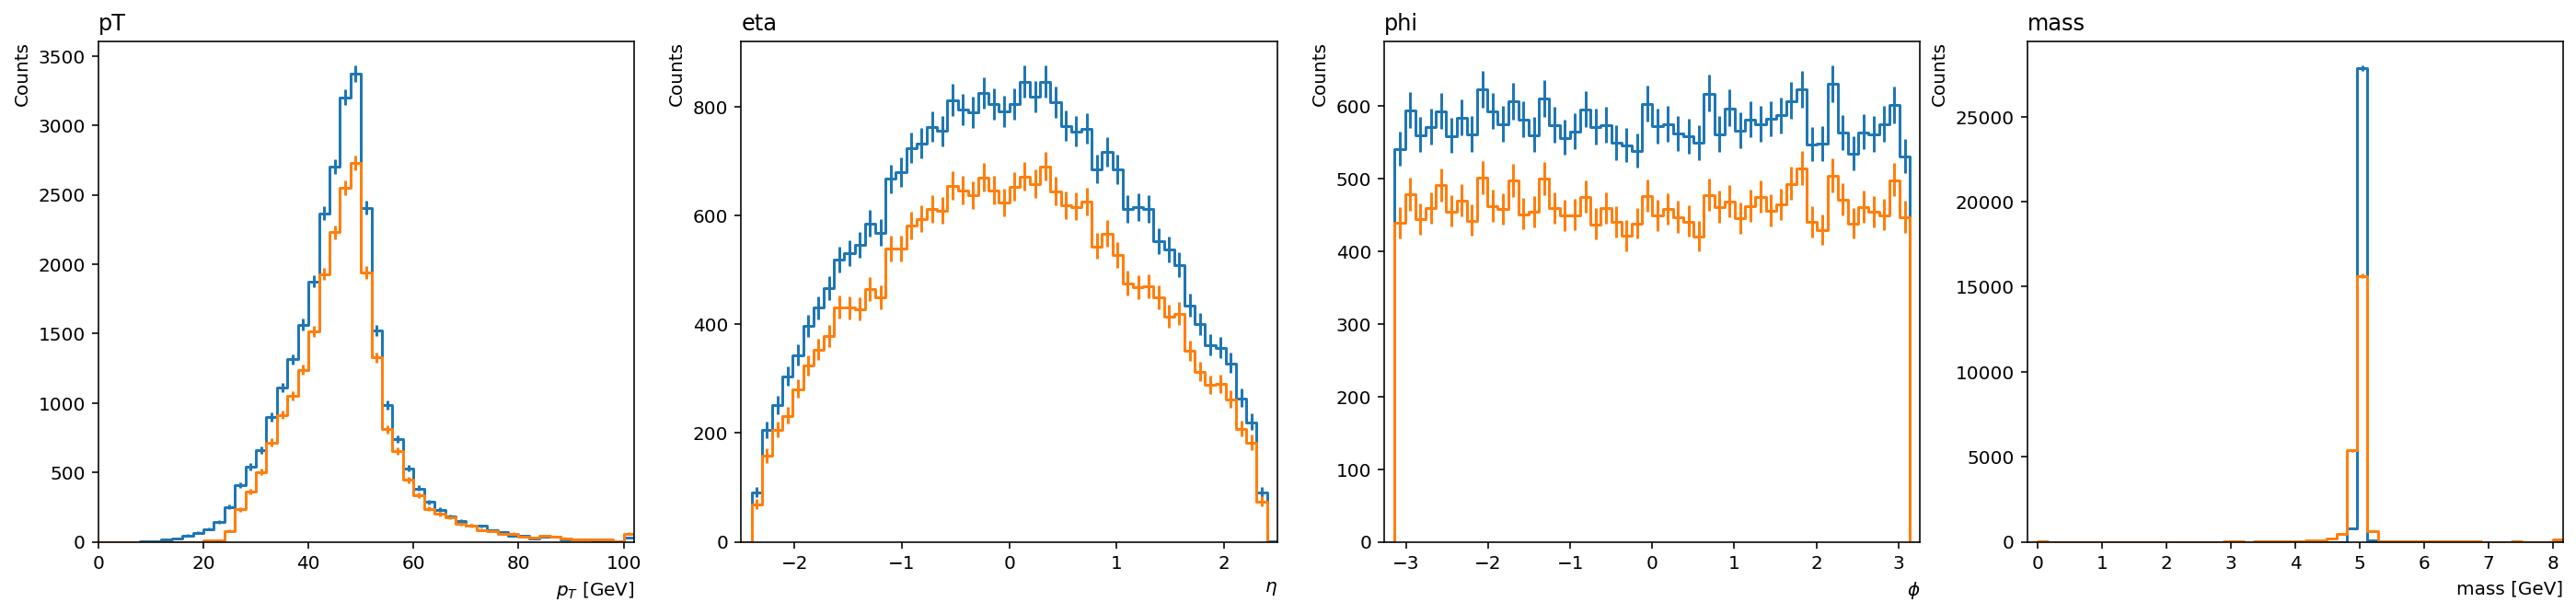

In [6]:
makeSinglePlot()

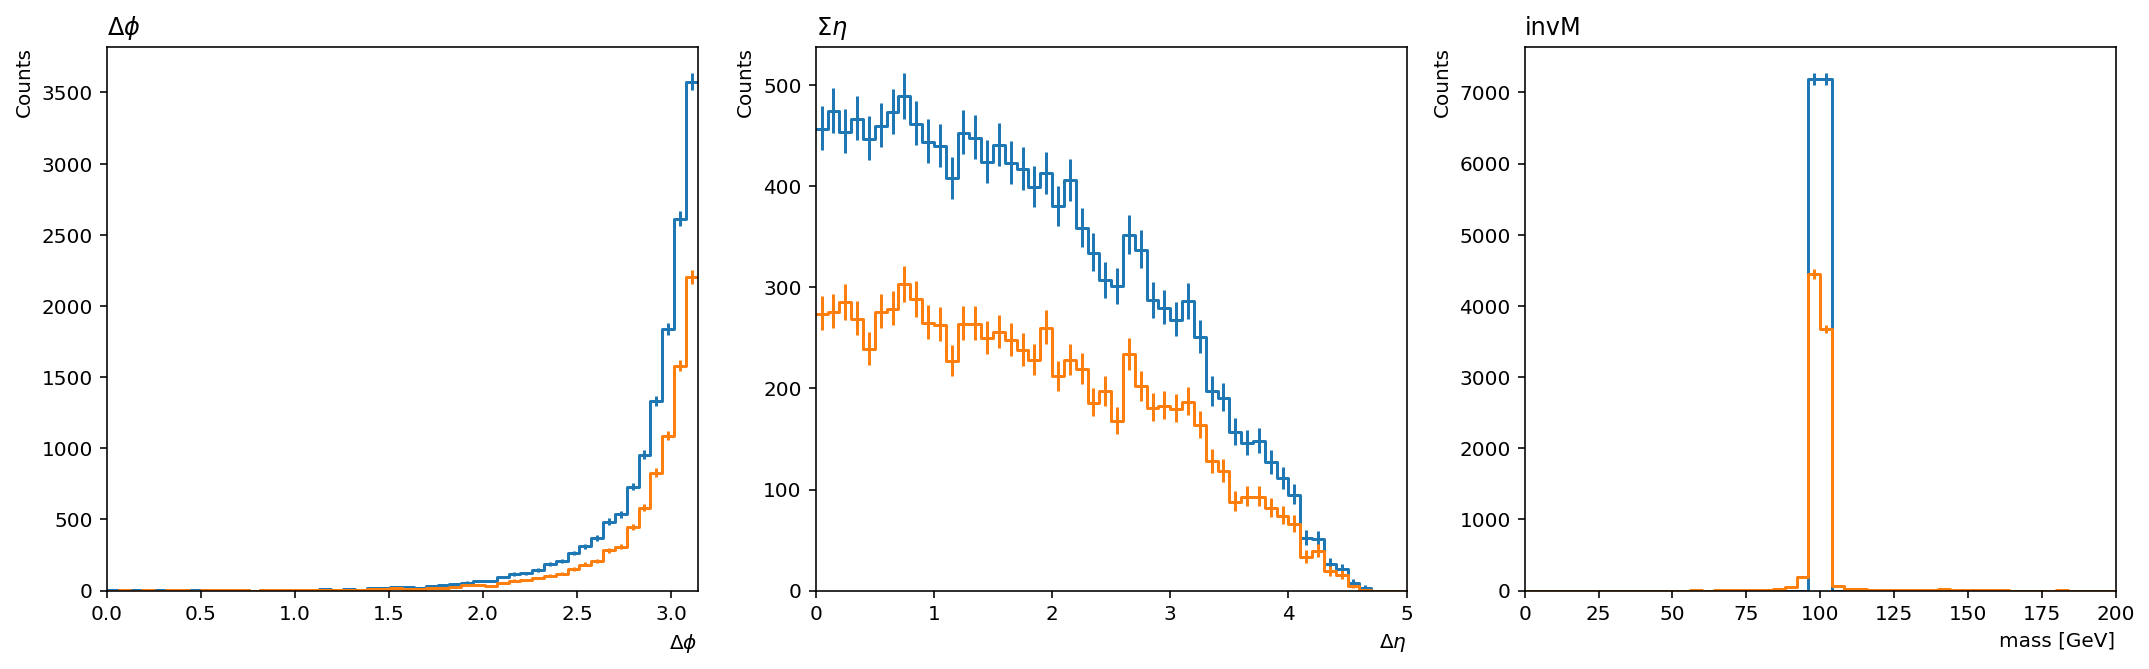

In [13]:
makePairPlot()

In [12]:
printContam()

[0, pi/2] - 0.89%


In [8]:
printCount()

events              14374
triggered            9162
nlj>=2               8647
nlj>=2&triggered     5794
dtype: int64


In [14]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.51s/items]


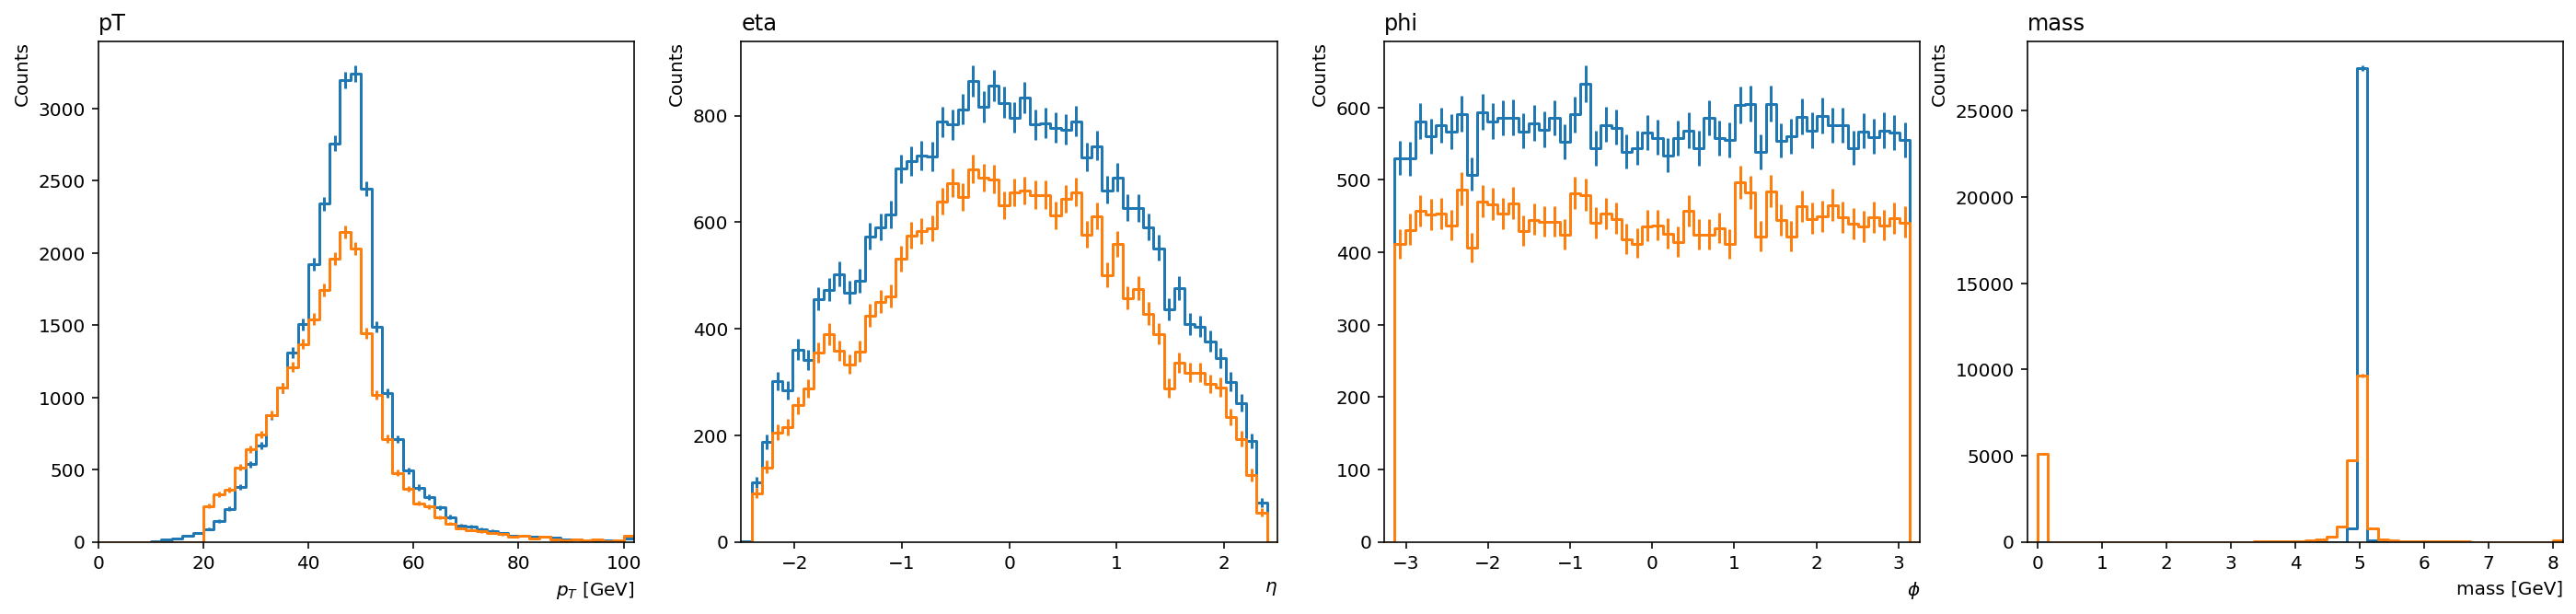

In [10]:
makeSinglePlot()

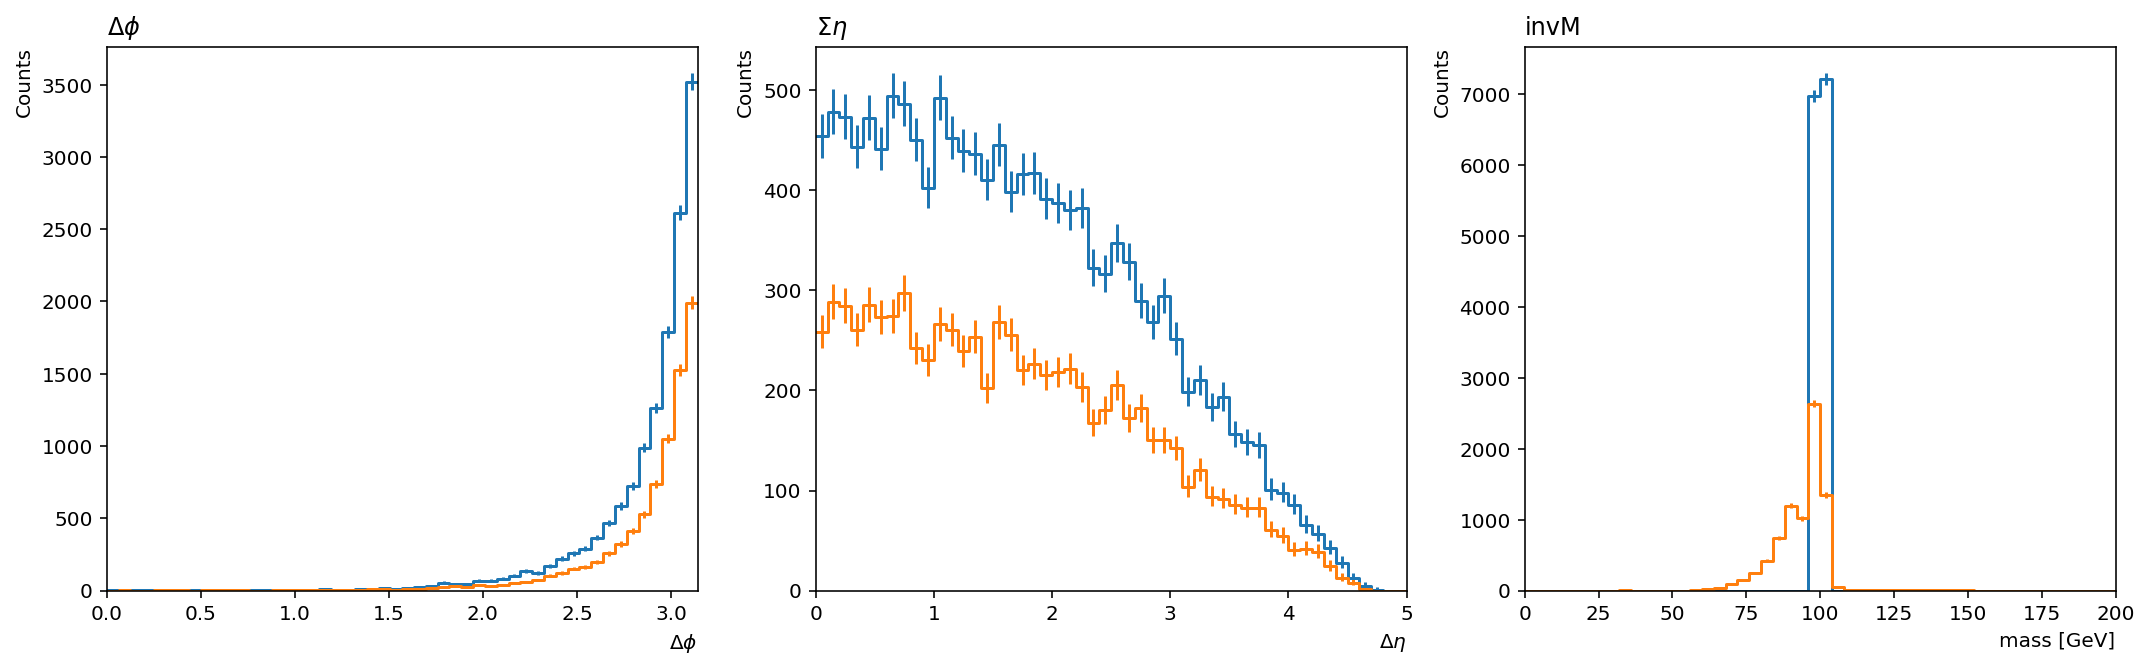

In [15]:
makePairPlot()

In [14]:
printContam()

[0, pi/2] - 0.66%


In [12]:
printCount()

events              14184
triggered            1210
nlj>=2               8033
nlj>=2&triggered      746
dtype: int64


In [15]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.33s/items]


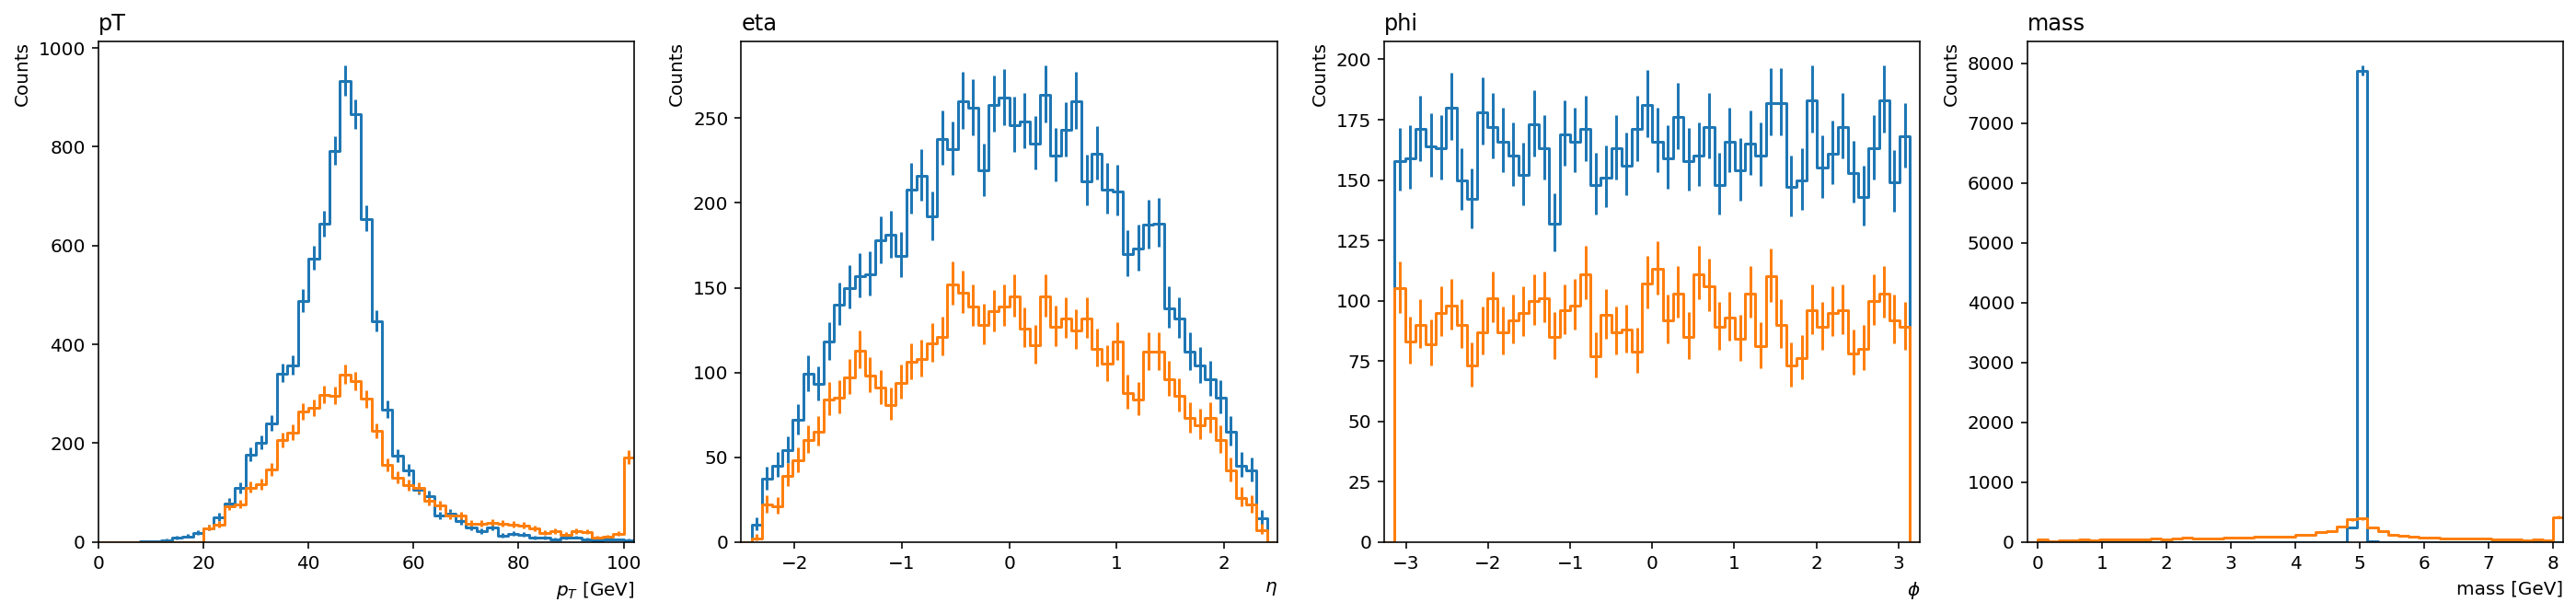

In [14]:
makeSinglePlot()

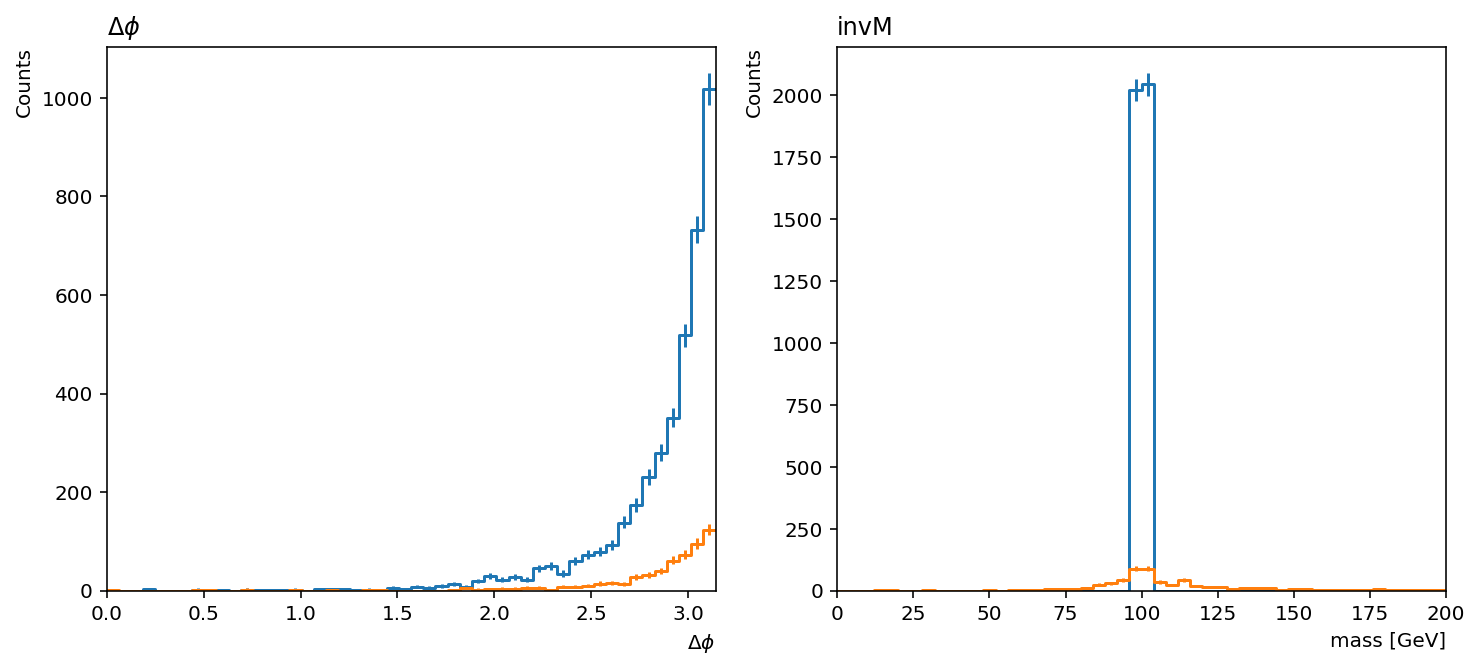

In [15]:
makePairPlot()

In [16]:
printContam()

[0, pi/2] - 1.62%


In [16]:
printCount()

events              4067
triggered           2356
nlj>=2               555
nlj>=2&triggered     369
dtype: int64


In [17]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.28s/items]


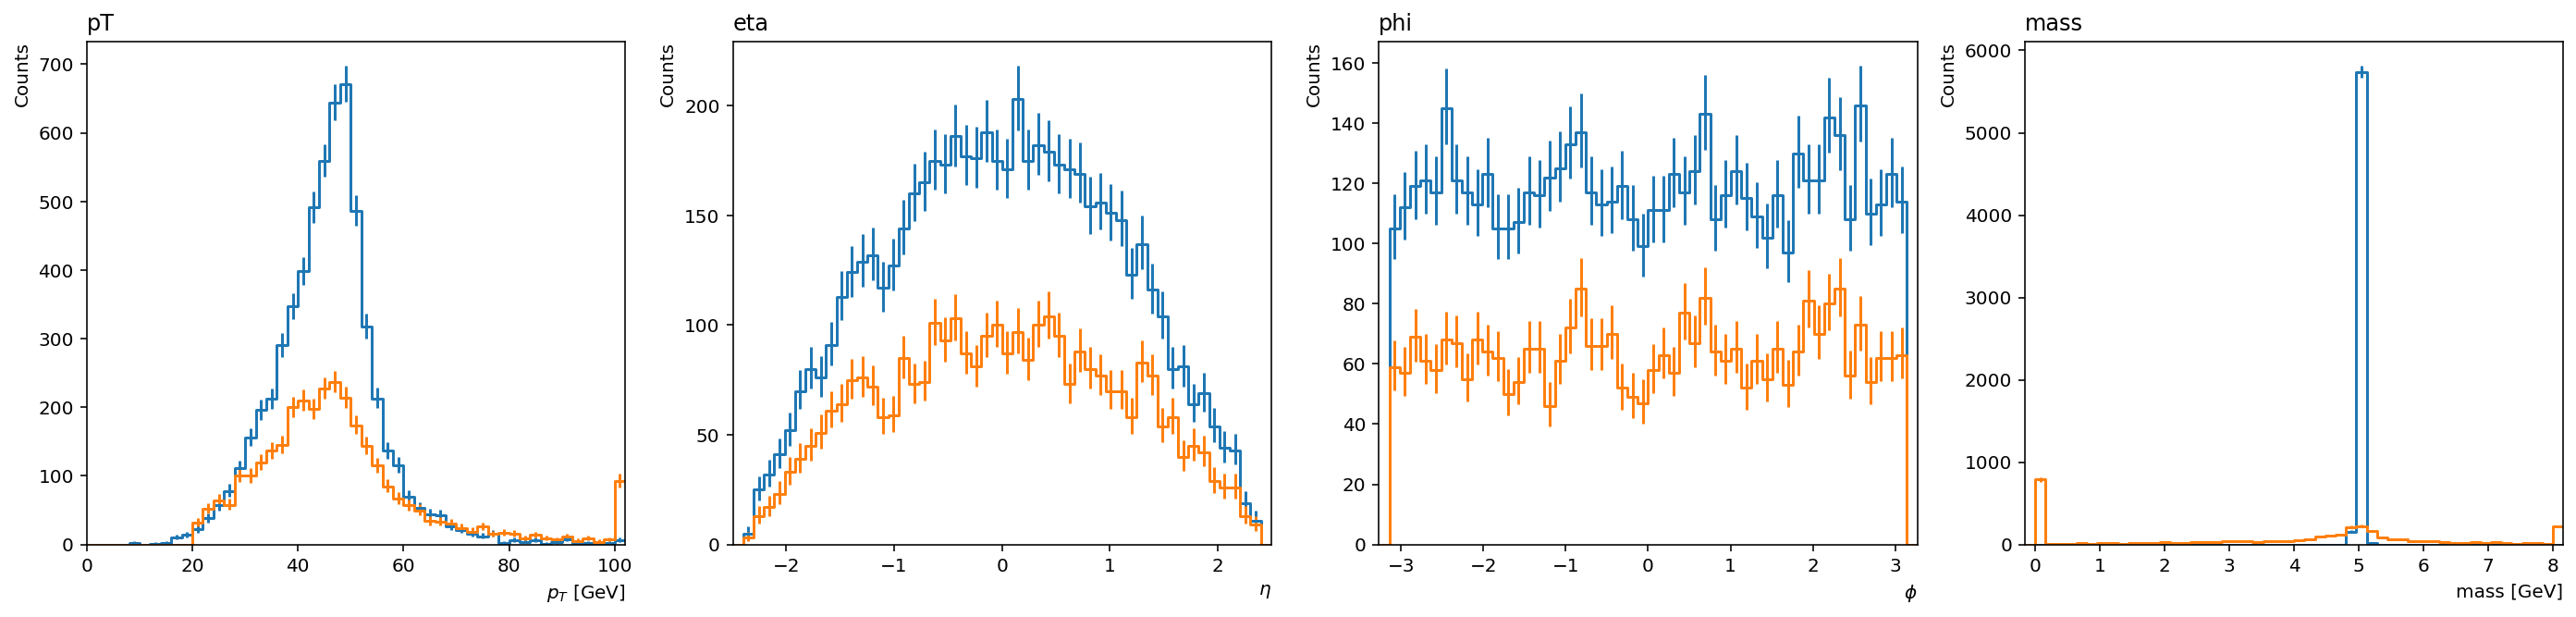

In [18]:
makeSinglePlot()

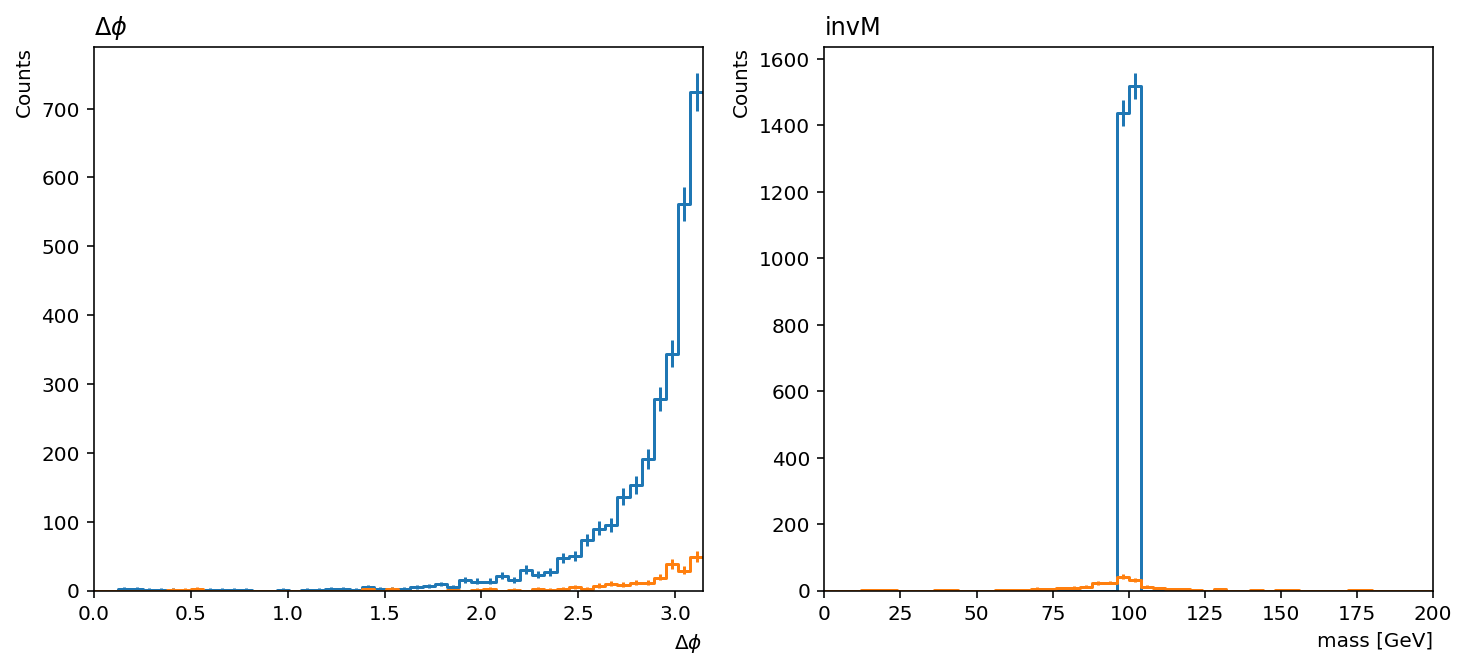

In [19]:
makePairPlot()

In [18]:
printContam()

[0, pi/2] - 3.81%


In [20]:
printCount()

events              2955
triggered            352
nlj>=2               210
nlj>=2&triggered      35
dtype: int64


In [19]:
class myprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 50, 0, 1000)
        eta_axis = hist.Bin('eta', '$\eta$', 50, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        mass_axis = hist.Bin('mass', 'mass [GeV]', 50, 0, 1)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        invm_axis = hist.Bin('invm', 'mass [GeV]', 50, 0, 2000)
        self._accumulator = processor.dict_accumulator({
            'darkphoton': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis, phi_axis, mass_axis),
            'leptonjet': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis, phi_axis, mass_axis),
            'dppair': hist.Hist('Counts', dataset_axis, dphi_axis, invm_axis),
            'ljpair': hist.Hist('Counts', dataset_axis, dphi_axis, invm_axis),
            'countbook': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        output['countbook']['events'] += df.size
        output['countbook']['triggered'] += triggermask.astype(int).sum()
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['gen_p4.fCoordinates.fX'],
                                                 df['gen_p4.fCoordinates.fY'],
                                                 df['gen_p4.fCoordinates.fZ'],
                                                 df['gen_p4.fCoordinates.fT']),
            pid=df['gen_pid'],
        )
        darkphotons = genparticles[genparticles.pid==32]
        output['darkphoton'].fill(dataset=dataset,
                                 pt=darkphotons.pt.flatten(),
                                 eta=darkphotons.eta.flatten(),
                                 phi=darkphotons.phi.flatten(),
                                 mass=darkphotons.mass.flatten())
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
        )
        output['leptonjet'].fill(dataset=dataset,
                                pt=leptonjets.pt.flatten(),
                                eta=leptonjets.eta.flatten(),
                                phi=leptonjets.phi.flatten(),
                                mass=leptonjets.mass.flatten())
        dp0 = darkphotons[:, 0:1]
        dp1 = darkphotons[:, 1:2]
        output['dppair'].fill(dataset=dataset,
                             dphi=np.abs(dp0.p4.delta_phi(dp1.p4)).flatten(),
                             invm=(dp0.p4+dp1.p4).mass.flatten())
        
        
        ljs = leptonjets[leptonjets.counts>1]
        if ljs.size==0:
            return output
        output['countbook']['nlj>=2'] += (leptonjets.counts>1).astype(int).sum()
        output['countbook']['nlj>=2&triggered'] += (leptonjets.counts>1)[triggermask].astype(int).sum()
        lj0 = ljs[ljs.pt.argmax()]
        lj1 = ljs[ljs.pt.argsort()[:, 1:2]]
        output['ljpair'].fill(dataset=dataset,
                              dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(),
                              invm=(lj0.p4+lj1.p4).mass.flatten(),
                             )
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [20]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:05<00:00,  1.16s/items]


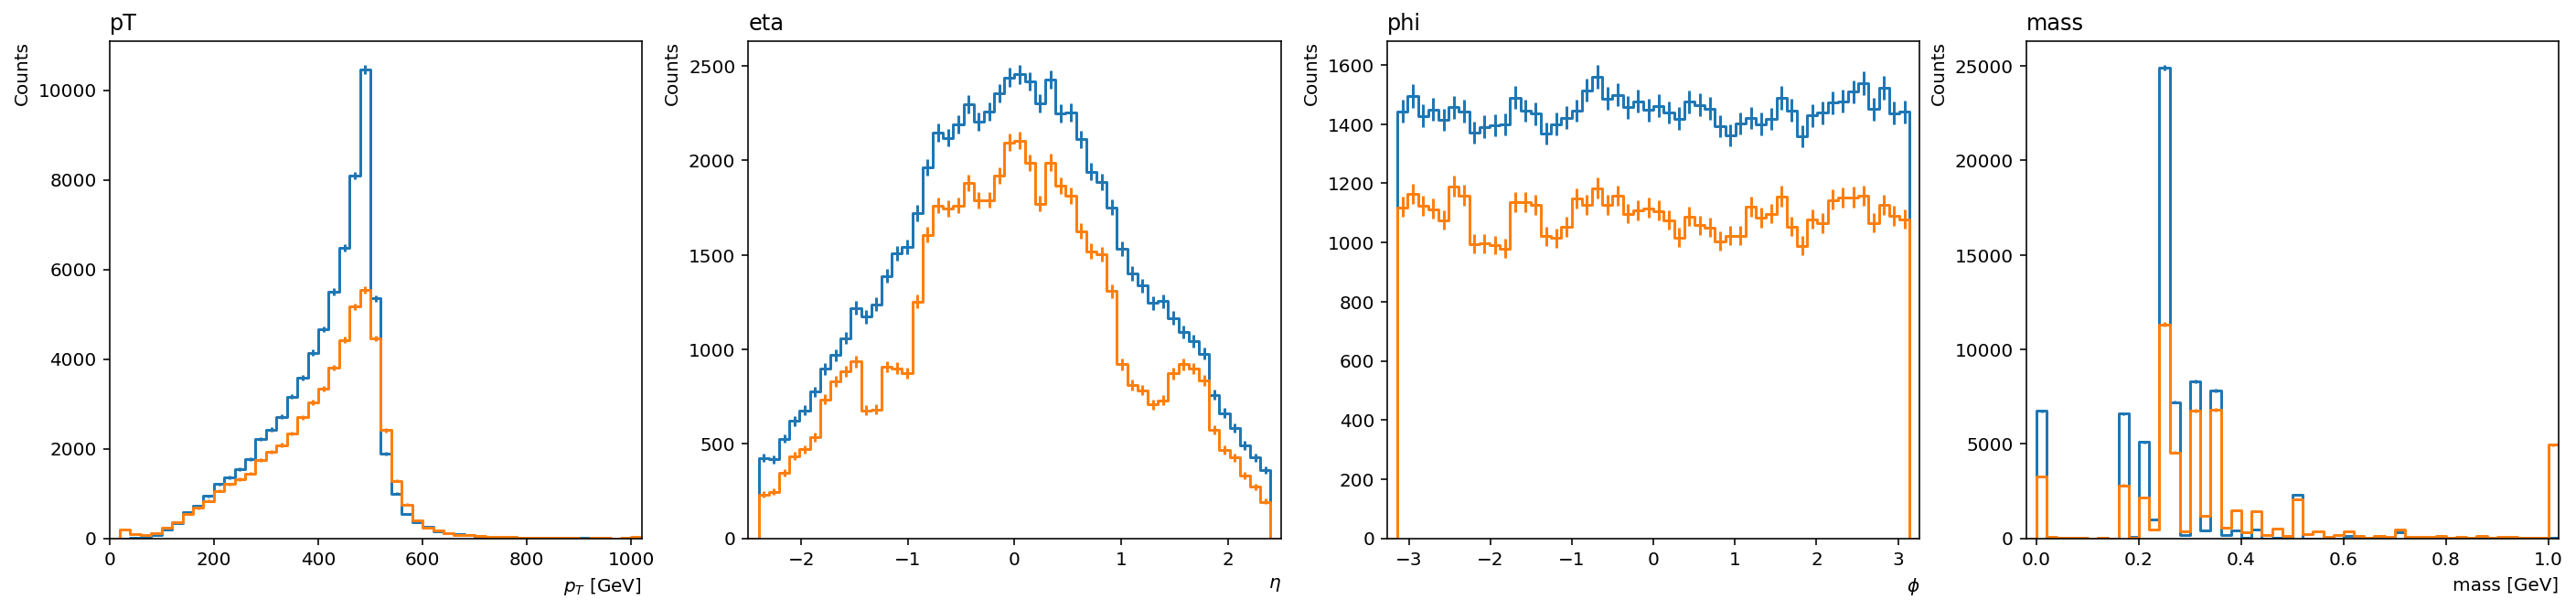

In [23]:
makeSinglePlot()

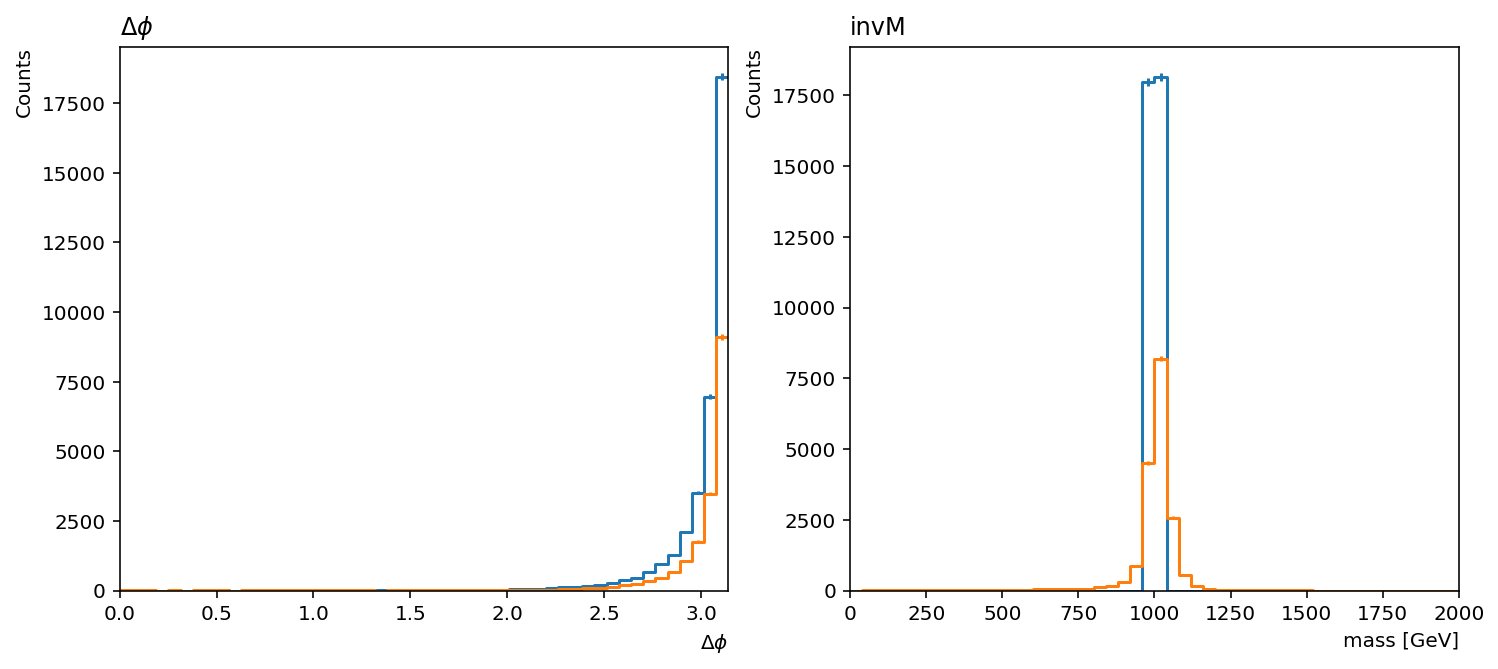

In [24]:
makePairPlot()

In [21]:
printContam()

[0, pi/2] - 0.95%


In [25]:
printCount()

events              36122
triggered           33147
nlj>=2              18222
nlj>=2&triggered    16887
dtype: int64


In [22]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:05<00:00,  1.15s/items]


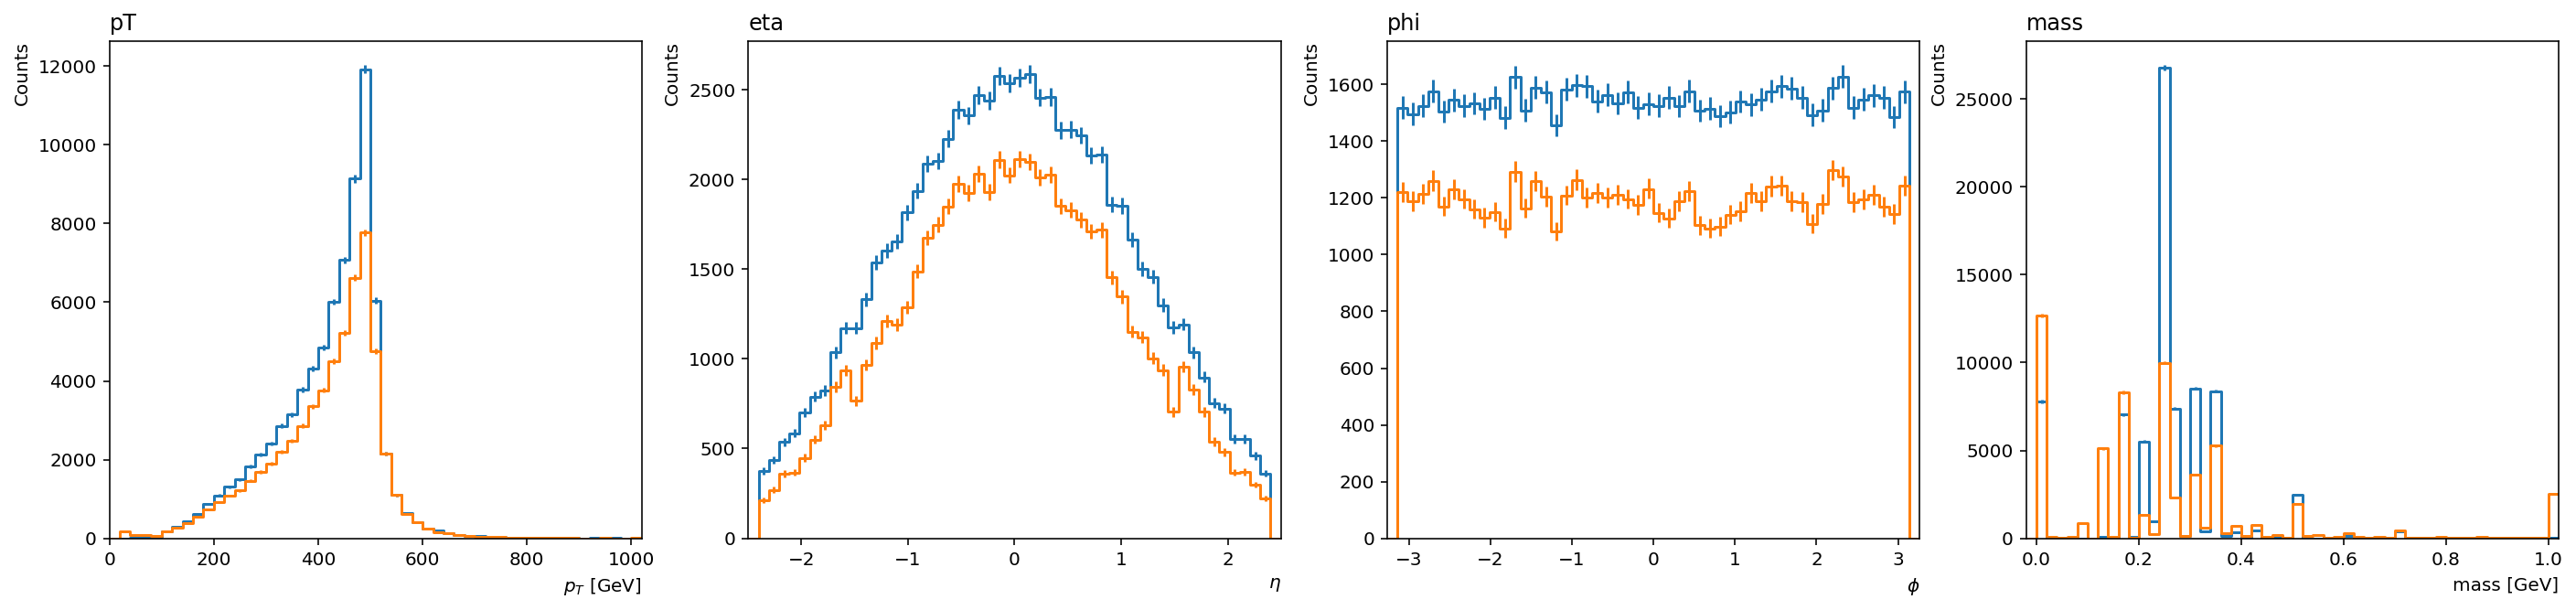

In [27]:
makeSinglePlot()

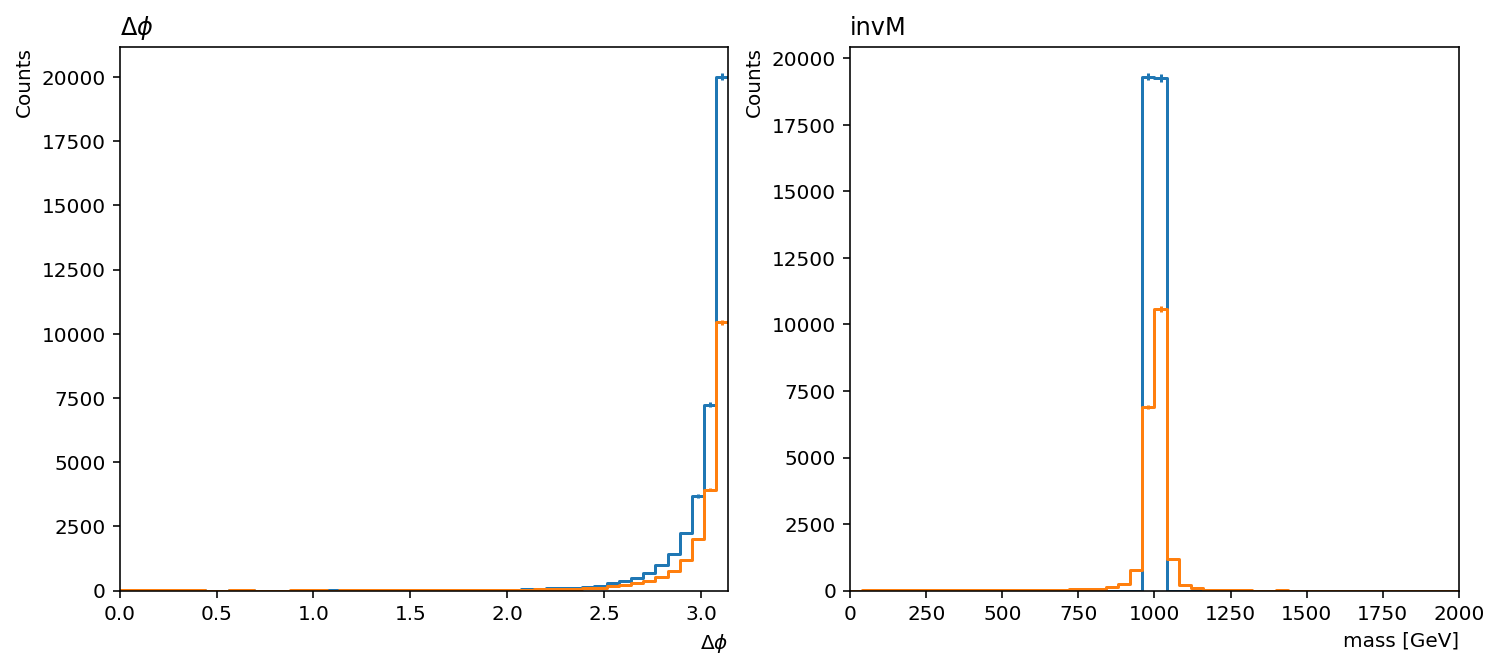

In [28]:
makePairPlot()

In [23]:
printContam()

[0, pi/2] - 0.69%


In [29]:
printCount()

events              38566
triggered           13907
nlj>=2              20673
nlj>=2&triggered     8225
dtype: int64


In [24]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.17items/s]


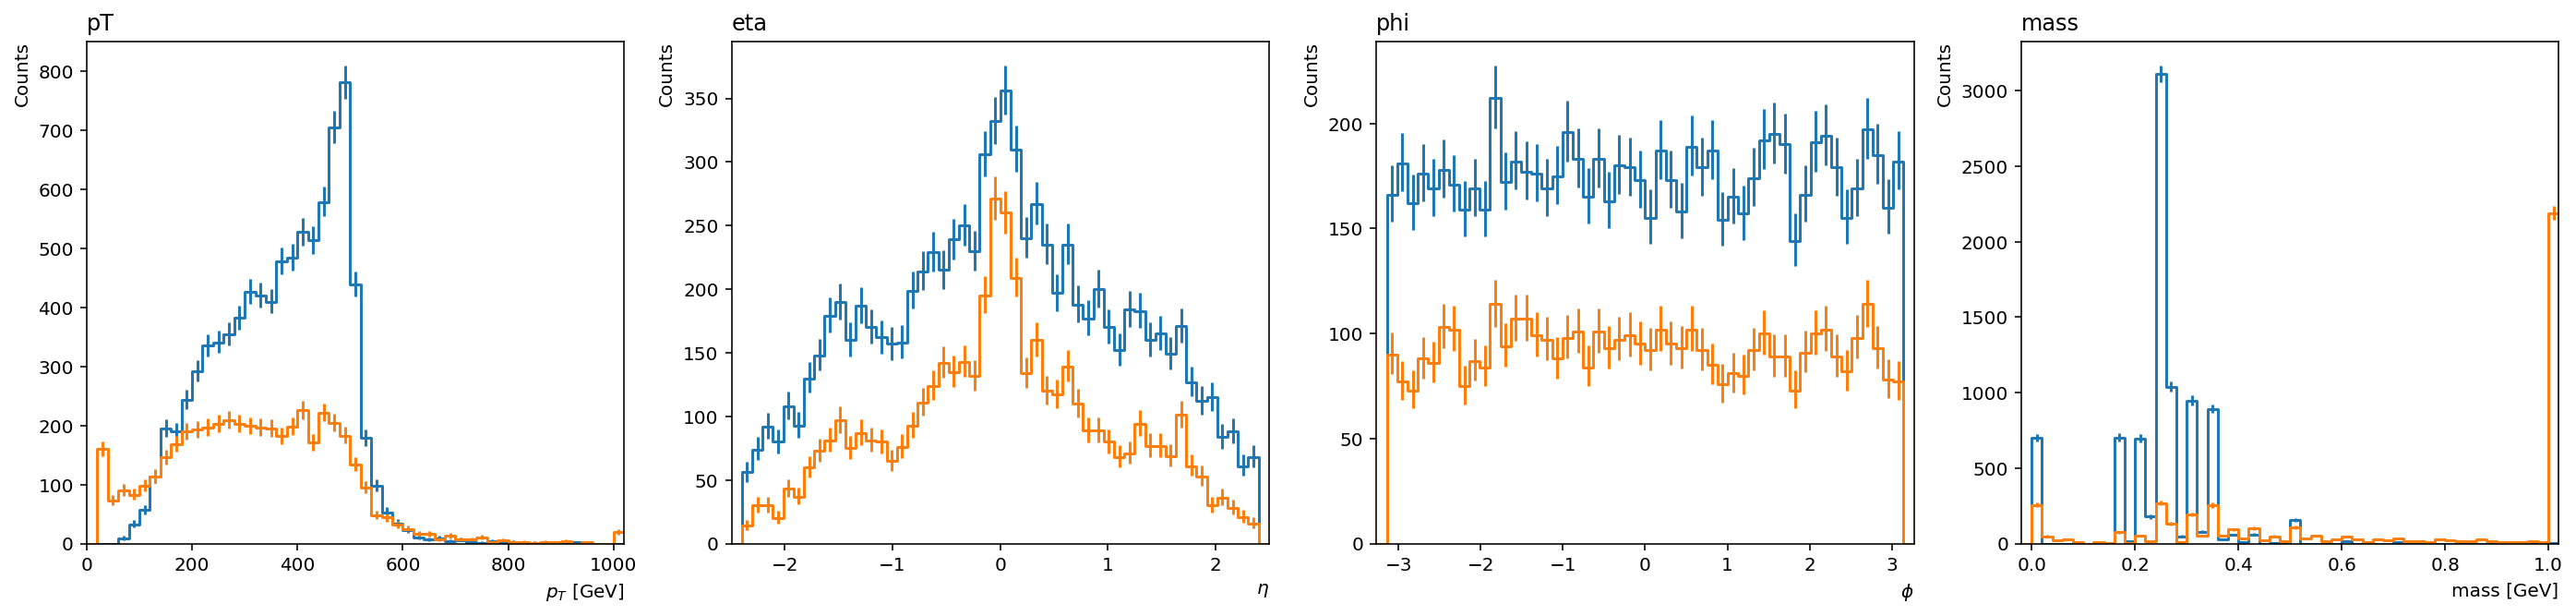

In [31]:
makeSinglePlot()

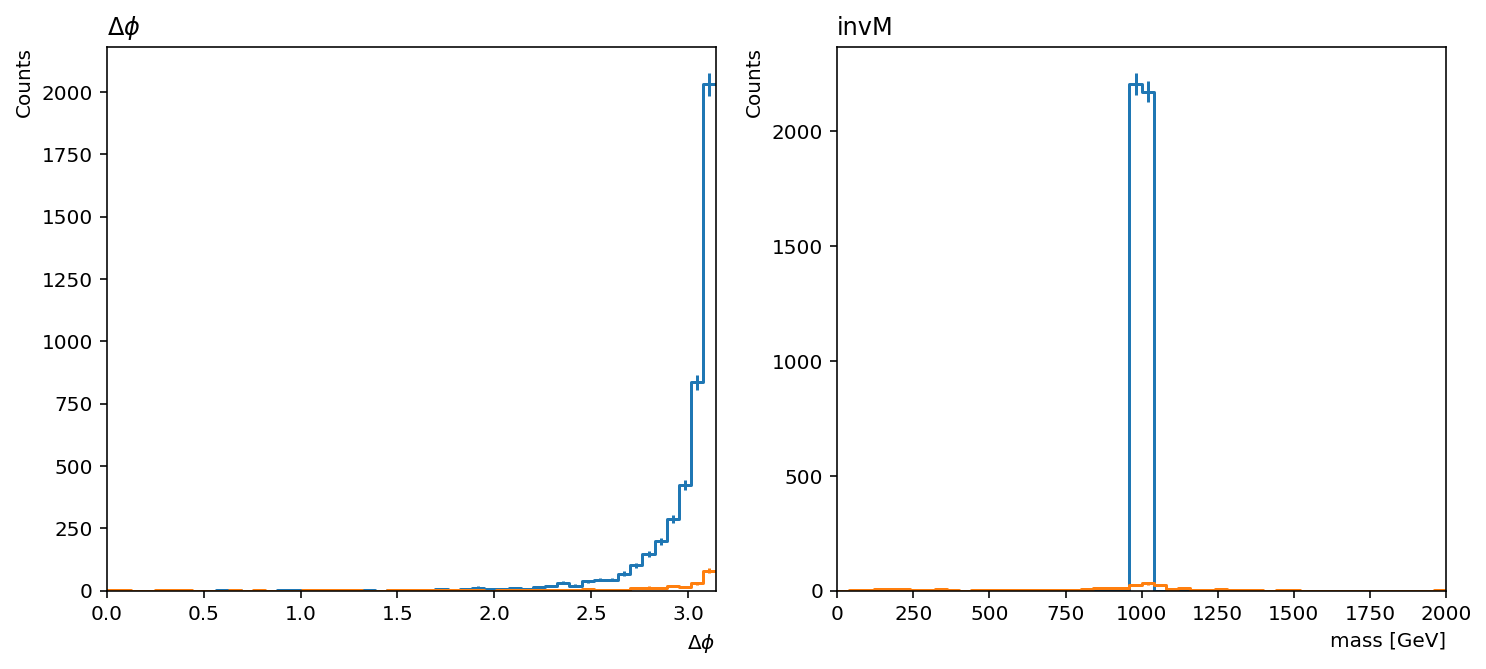

In [32]:
makePairPlot()

In [25]:
printContam()

[0, pi/2] - 9.29%


In [33]:
printCount()

events              4376
triggered           3608
nlj>=2               226
nlj>=2&triggered     218
dtype: int64


In [26]:
dataset={
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.13items/s]


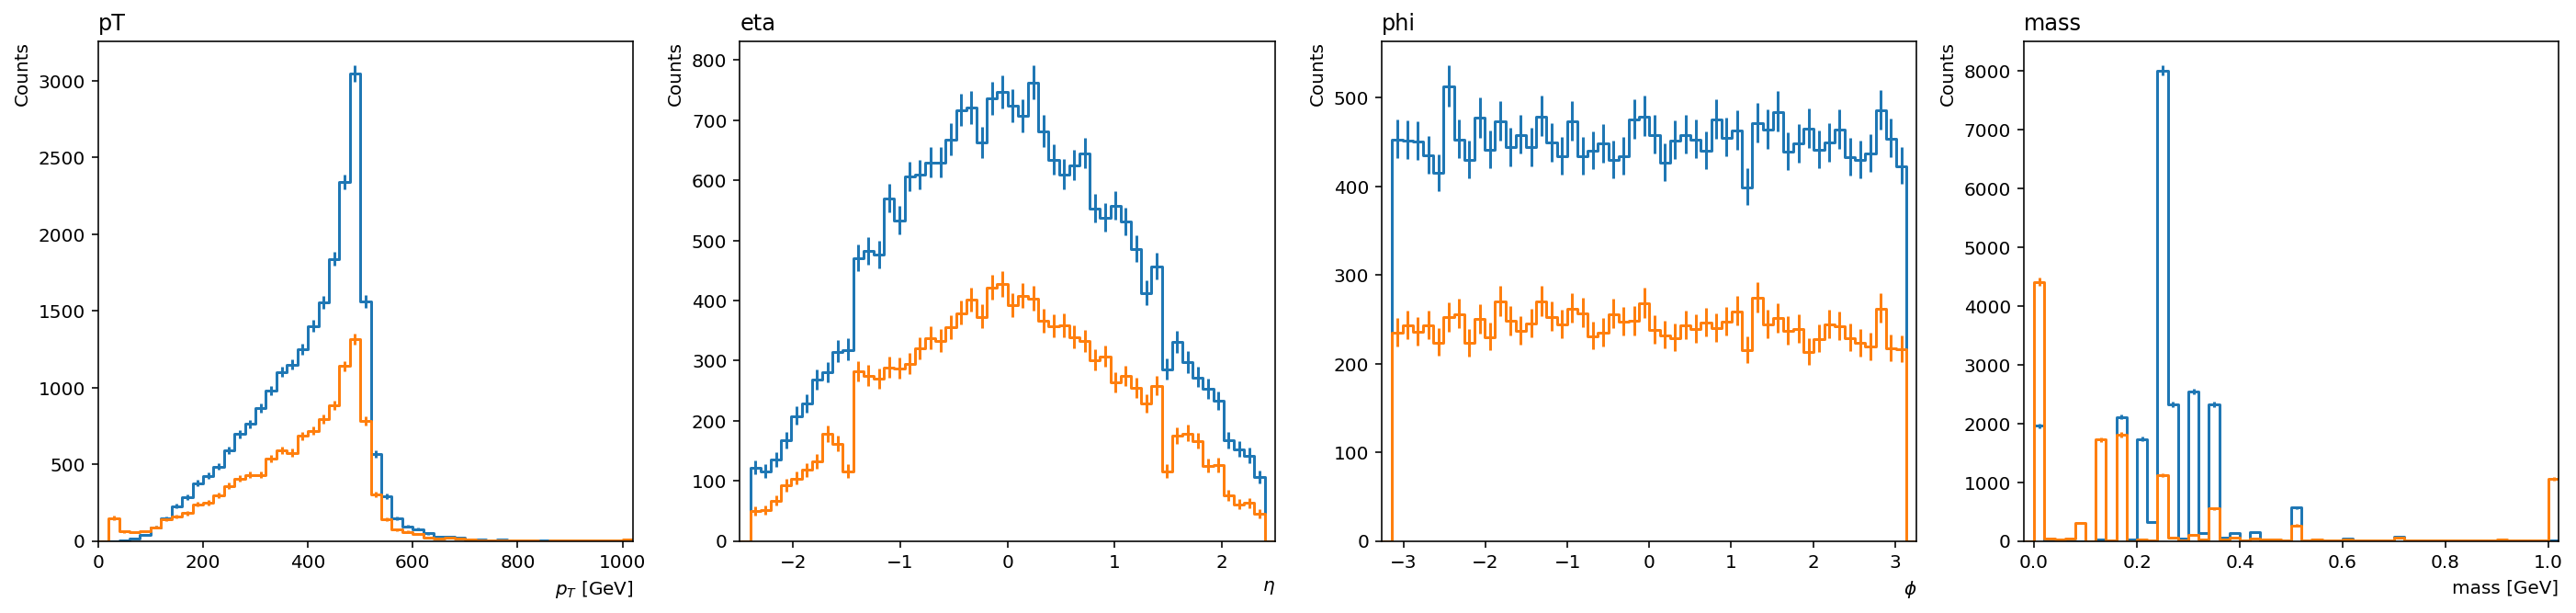

In [35]:
makeSinglePlot()

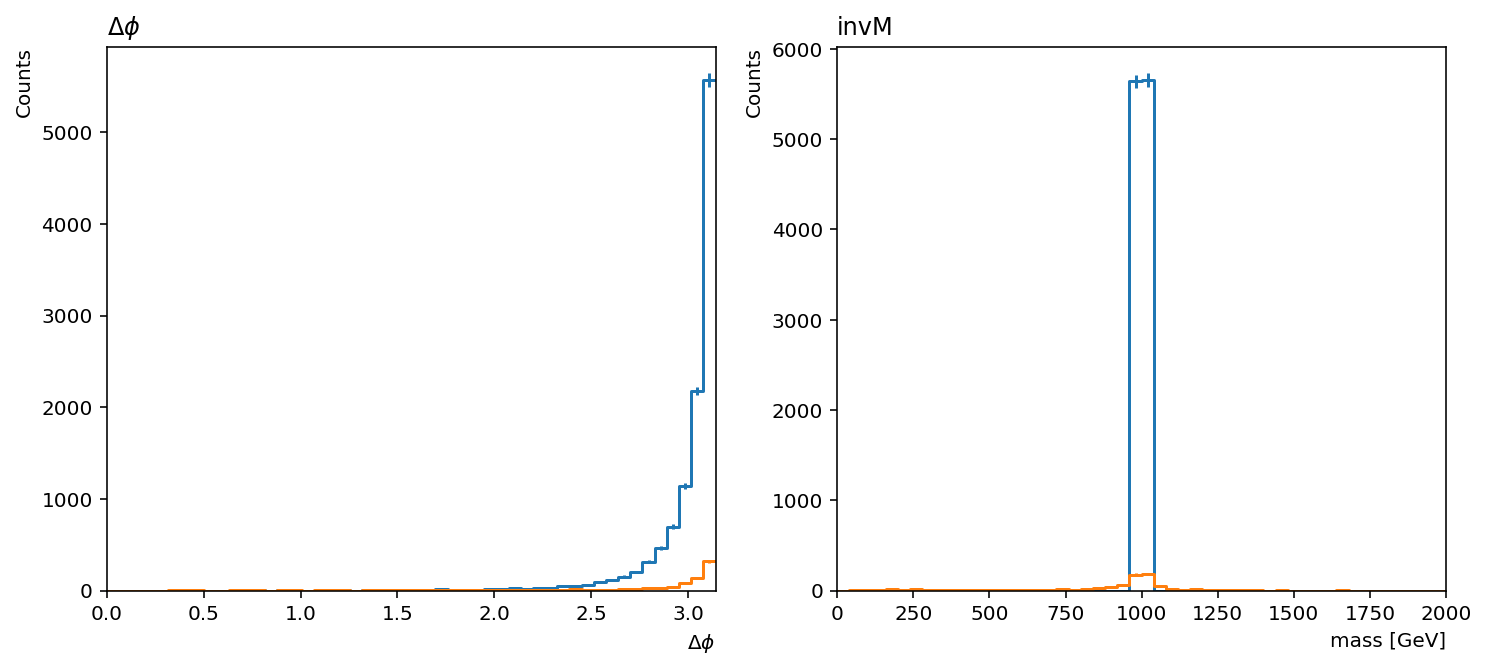

In [36]:
makePairPlot()

In [27]:
printContam()

[0, pi/2] - 6.05%


In [37]:
printCount()

events              11291
triggered            1626
nlj>=2                793
nlj>=2&triggered      327
dtype: int64


In [44]:
class bkgprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 50, 0, 1000)
        eta_axis = hist.Bin('eta', '$\eta$', 50, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        mass_axis = hist.Bin('mass', 'mass [GeV]', 50, 0, 5)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        invm_axis = hist.Bin('invm', 'mass [GeV]', 50, 0, 2000)
        self._accumulator = processor.dict_accumulator({
            'leptonjet': hist.Hist('Counts', dataset_axis, pt_axis, eta_axis, phi_axis, mass_axis),
            'ljpair': hist.Hist('Counts', dataset_axis, dphi_axis, invm_axis),
            'countbook': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        output['countbook']['events'] += df.size
        output['countbook']['triggered'] += triggermask.astype(int).sum()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
        )
        leptonjets=leptonjets[leptonjets.pt>20]
        output['leptonjet'].fill(dataset=dataset,
                                pt=leptonjets.pt.flatten(),
                                eta=leptonjets.eta.flatten(),
                                phi=leptonjets.phi.flatten(),
                                mass=leptonjets.mass.flatten())
        
        ljs = leptonjets[leptonjets.counts>1]
        if ljs.size==0:
            return output
        output['countbook']['nlj>=2'] += (leptonjets.counts>1).astype(int).sum()
        output['countbook']['nlj>=2&triggered'] += (leptonjets.counts>1)[triggermask].astype(int).sum()
        lj0 = ljs[ljs.pt.argmax()]
        lj1 = ljs[ljs.pt.argsort()[:, 1:2]]
        output['ljpair'].fill(dataset=dataset,
                              dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(),
                              invm=(lj0.p4+lj1.p4).mass.flatten(),
                             )
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [45]:
dataset={'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120']}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=bkgprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 147/147 [00:38<00:00,  3.80items/s]


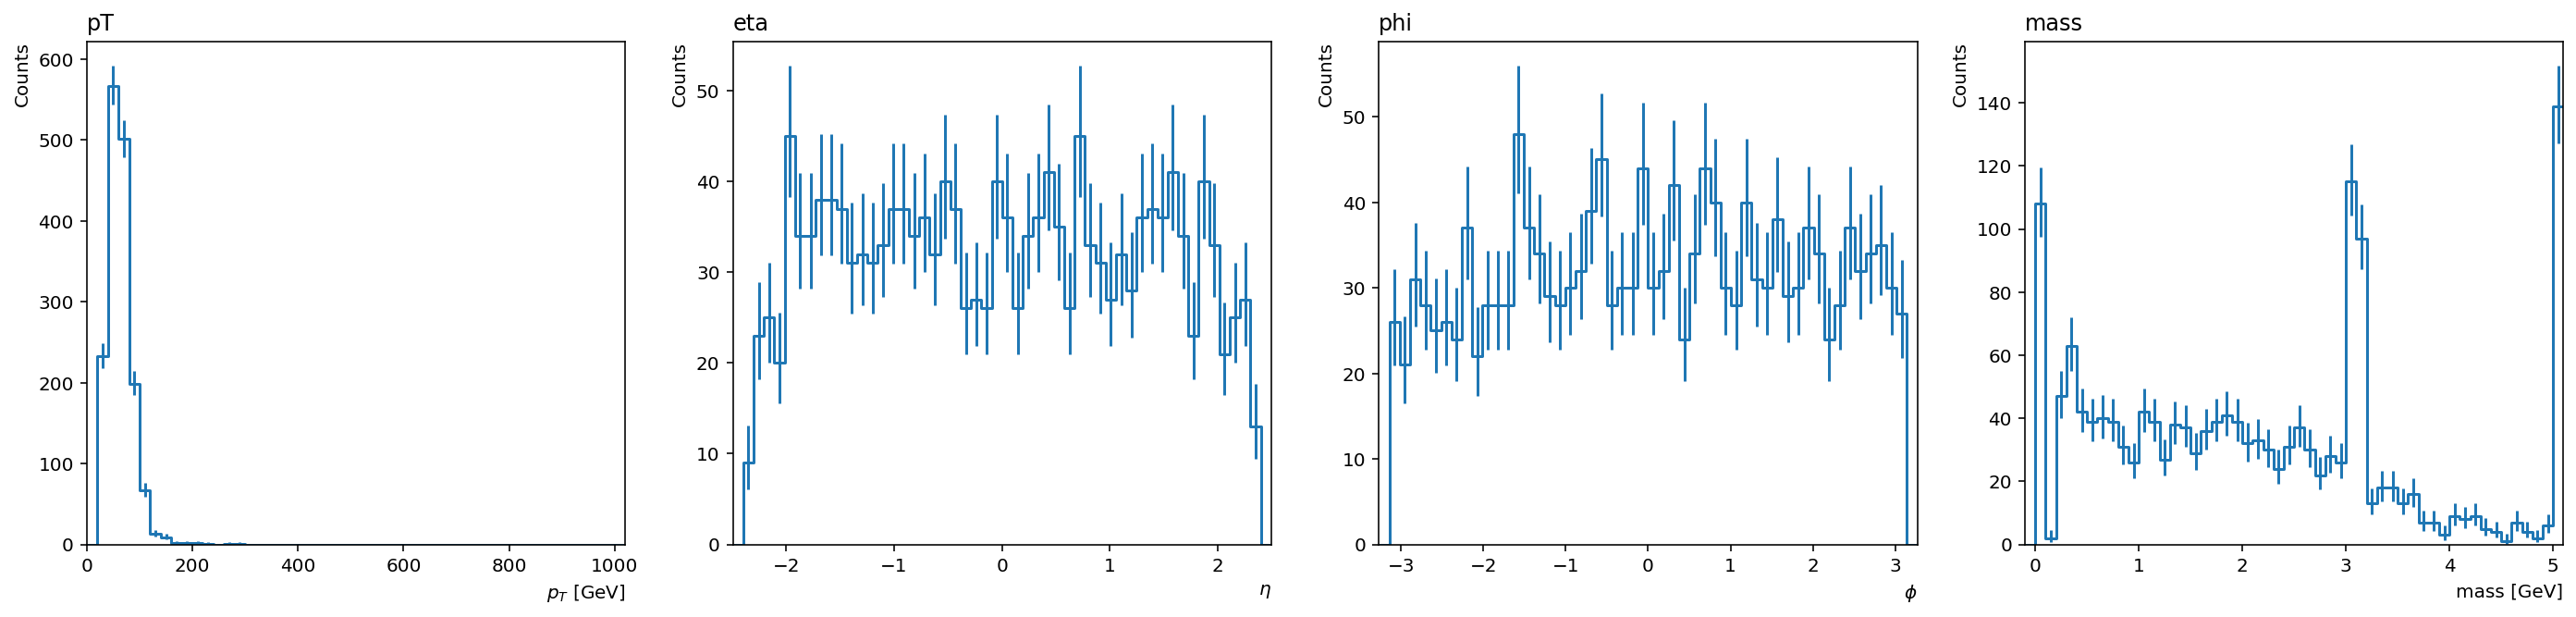

In [46]:
fig,axes = plt.subplots(1,4,figsize=(24, 5))
hist.plot1d(output['leptonjet'].sum('dataset', 'eta', 'phi', 'mass', overflow='all'), overflow='over', ax=axes[0] )
axes[0].set_title('pT', x=0., ha='left')

hist.plot1d(output['leptonjet'].sum('dataset', 'pt', 'phi', 'mass', overflow='all'), overflow='all', ax=axes[1], )
axes[1].set_title('eta', x=0., ha='left')

hist.plot1d(output['leptonjet'].sum('dataset', 'pt', 'eta', 'mass', overflow='all'), overflow='all', ax=axes[2], )
axes[2].set_title('phi', x=0., ha='left')

hist.plot1d(output['leptonjet'].sum('dataset', 'pt', 'eta', 'phi', overflow='all'), overflow='all', ax=axes[3], )
axes[3].set_title('mass', x=0., ha='left')

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

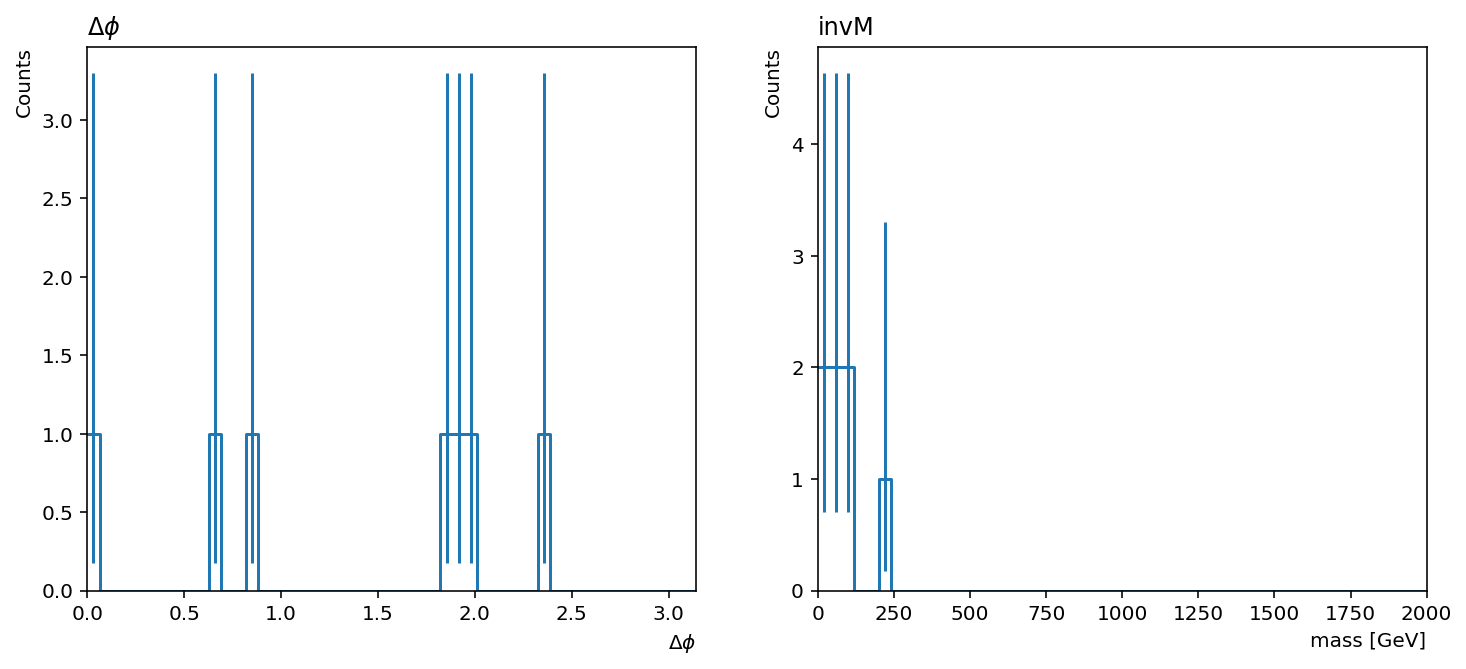

In [47]:
fig, axes=plt.subplots(1,2,figsize=(12, 5))
hist.plot1d(output['ljpair'].sum('dataset', 'invm', overflow='all'), ax=axes[0])
axes[0].set_title('$\Delta\phi$', x=0, ha='left')

hist.plot1d(output['ljpair'].sum('dataset', 'dphi', overflow='all'), ax=axes[1])
axes[1].set_title('invM', x=0, ha='left')

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

In [48]:
printCount()

events              1591
triggered           1591
nlj>=2                 7
nlj>=2&triggered       7
dtype: int64


In [5]:
class ljprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        iso_axis = hist.Bin('iso', 'pfiso', 50, 0, 1)
        nmu_axis = hist.Bin('nmu', '# mu', 4, 0, 4)
        ne_axis = hist.Bin('ne', '# e', 4, 0, 4)
        self._accumulator = processor.dict_accumulator({
            'iso': hist.Hist('Counts', dataset_axis, iso_axis),
            'nmu': hist.Hist('Counts', dataset_axis, nmu_axis),
            'ne': hist.Hist('Counts', dataset_axis, ne_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
            iso=df['pfjet_pfiso'],
            nmu=df['pfjet_muon_n'],
            ne=df['pfjet_electron_n'],
        )
        leptonjets=leptonjets[leptonjets.pt>20]
        
        output['iso'].fill(dataset=dataset, iso=leptonjets.iso.flatten())
        output['nmu'].fill(dataset=dataset, nmu=leptonjets.nmu.flatten())
        output['ne'].fill(dataset=dataset, ne=leptonjets.ne.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [13]:
dataset={
    'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 169/169 [00:08<00:00, 20.88items/s]


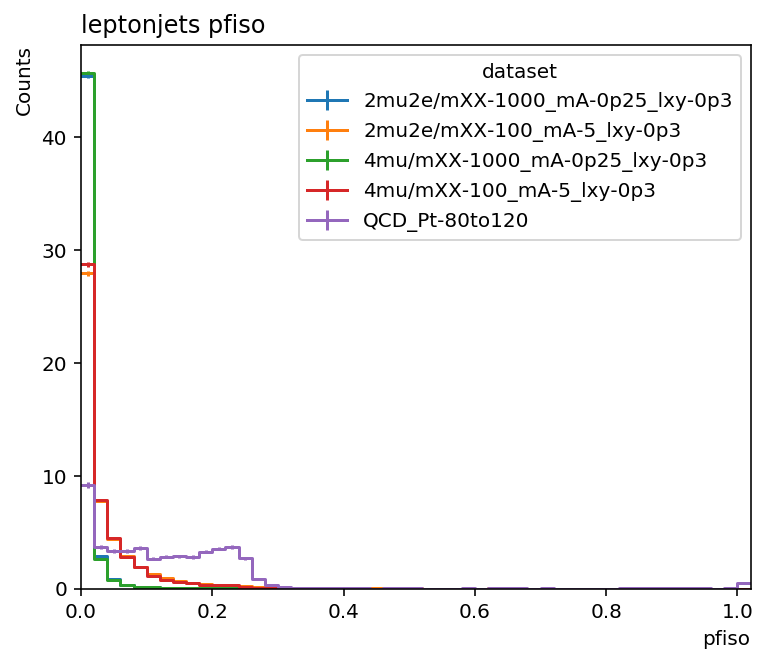

In [14]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['iso'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_title('leptonjets pfiso', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

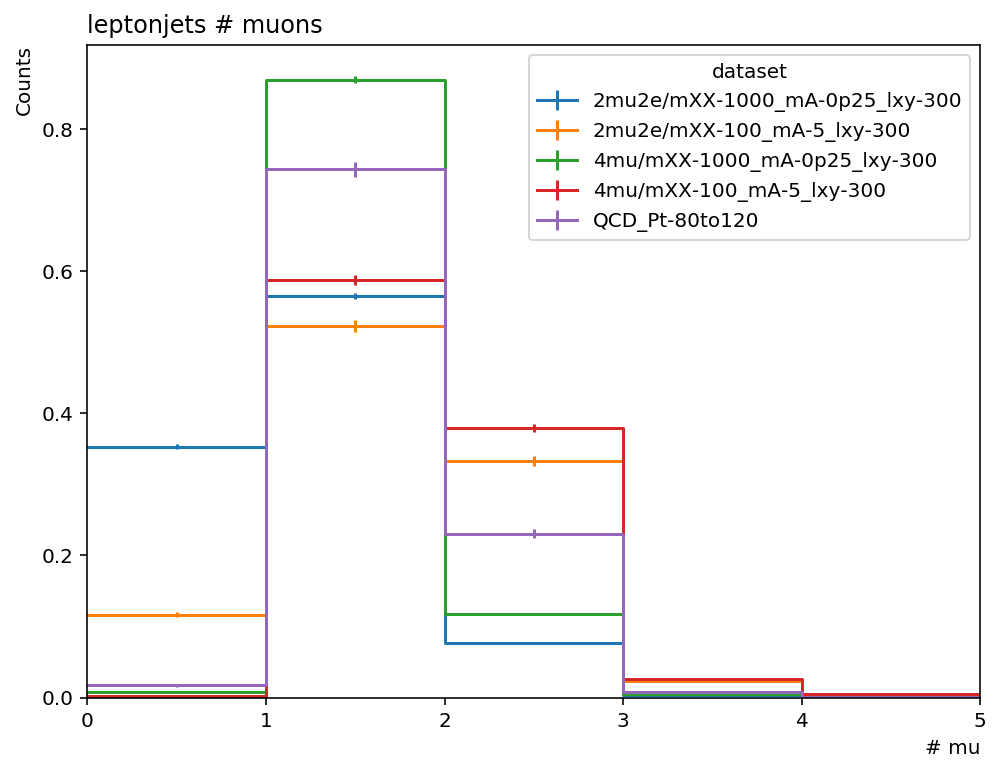

In [11]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['nmu'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_title('leptonjets # muons', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

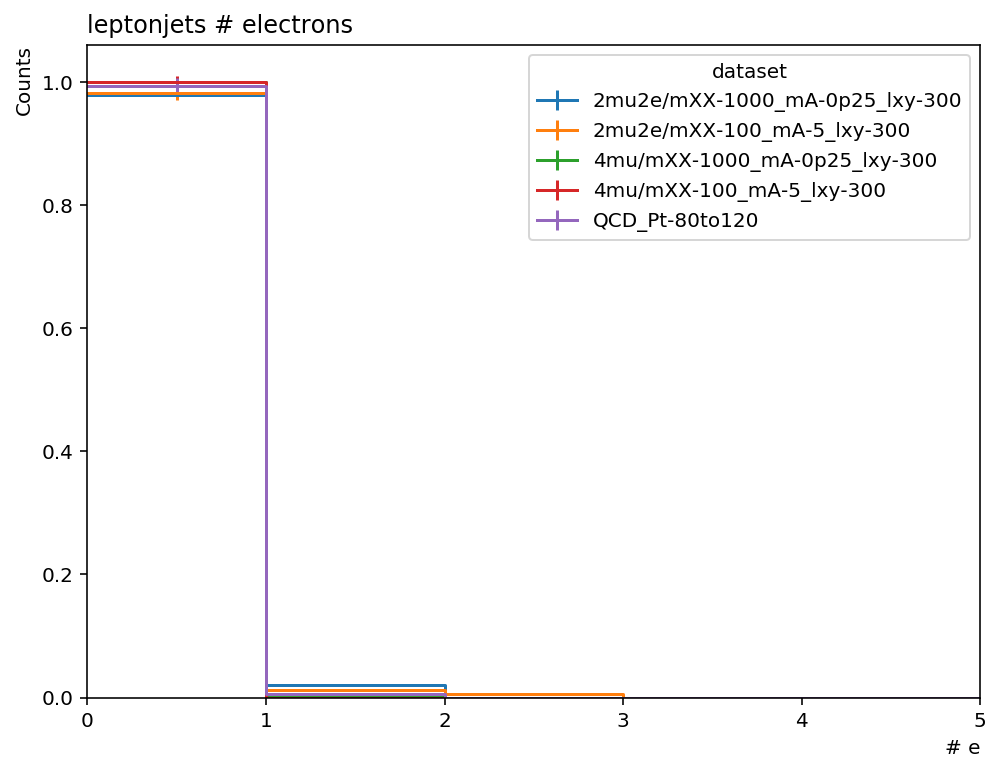

In [12]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['ne'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_title('leptonjets # electrons', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [16]:
class ljprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        tkiso05_axis = hist.Bin('tkiso05', 'track isolation 0.5', 50, 0, 1)
        pfiso05_axis = hist.Bin('pfiso05', 'pfcands isolation 0.5', 50, 0, 1)
        hadiso05_axis = hist.Bin('hadiso05', 'hadron isolation 0.5', 50, 0, 2)
        pfiso_axis = hist.Bin('pfiso', 'pfiso', 30, 0, 0.3)
        mindr_axis = hist.Bin('mindr', 'min$\Delta$R', 50, 0.4, np.pi)
        self._accumulator = processor.dict_accumulator({
            'ljtkiso05': hist.Hist("#counts", dataset_axis, tkiso05_axis),# label_axis, channel_axis),
            'ljpfiso05': hist.Hist("#counts", dataset_axis, pfiso05_axis),# label_axis, channel_axis),
            'ljhadiso05': hist.Hist("#counts", dataset_axis, hadiso05_axis),# label_axis, channel_axis),
            'ljpfiso': hist.Hist("#counts", dataset_axis, pfiso_axis),# label_axis, channel_axis),
            'ljmindr': hist.Hist("#counts", dataset_axis, mindr_axis),# label_axis, channel_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
            tkiso05=df['pfjet_tkIsolation05'],
            pfiso05=df['pfjet_pfIsolation05'],
            hadiso05=df['pfjet_hadIsolation05'],
            pfiso=df['pfjet_pfiso'],
            mindr=df['pfjet_mindr'],
        )
        
        output['ljtkiso05'].fill(dataset=dataset, tkiso05=leptonjets.tkiso05.flatten())
        output['ljpfiso05'].fill(dataset=dataset, pfiso05=leptonjets.pfiso05.flatten())
        output['ljhadiso05'].fill(dataset=dataset, hadiso05=leptonjets.hadiso05.flatten())
        output['ljpfiso'].fill(dataset=dataset, pfiso=leptonjets.pfiso.flatten())
        output['ljmindr'].fill(dataset=dataset, mindr=leptonjets.mindr.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [17]:
dataset={
    'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=ljprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 168/168 [00:08<00:00, 20.74items/s]


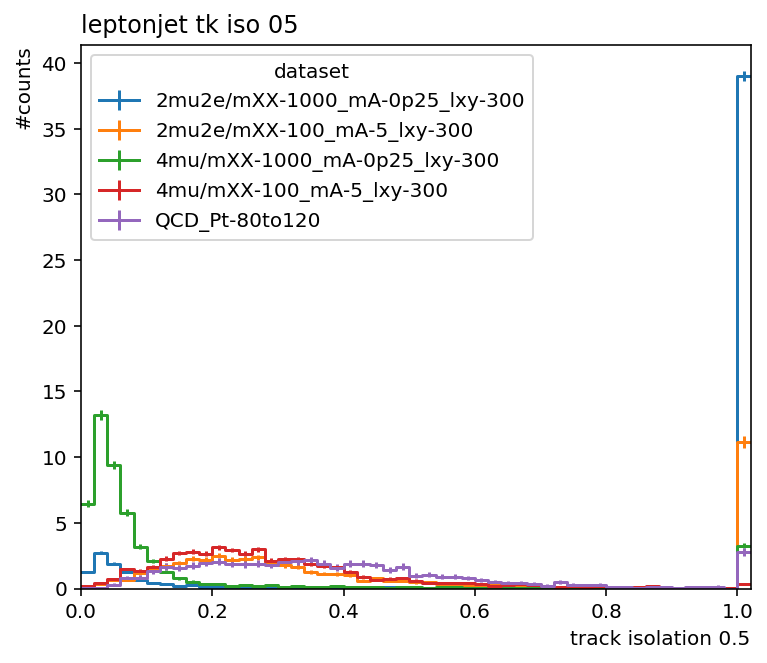

In [11]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['ljtkiso05'], overlay='dataset', ax=ax, overflow='over', density=True)
ax.set_title('leptonjet tk iso 05', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

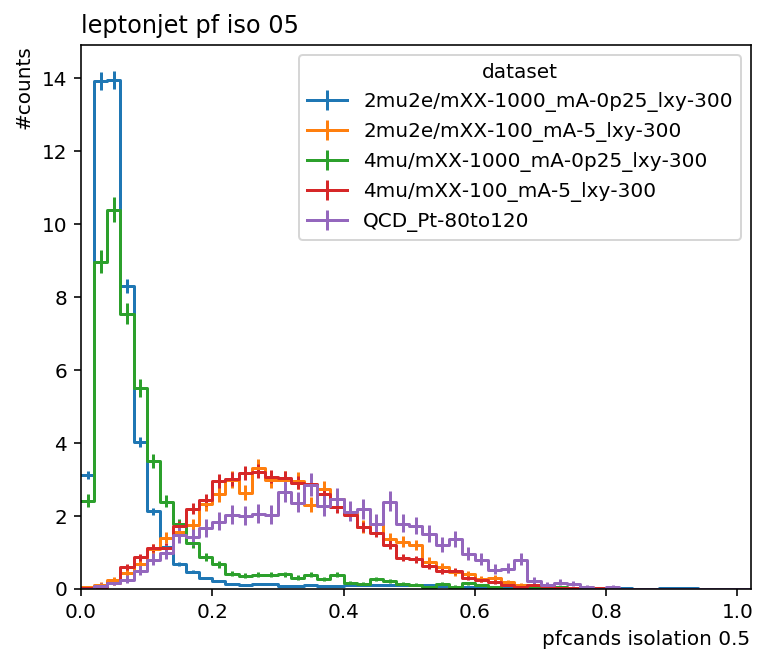

In [12]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['ljpfiso05'], overlay='dataset', ax=ax, overflow='over', density=True)
ax.set_title('leptonjet pf iso 05', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

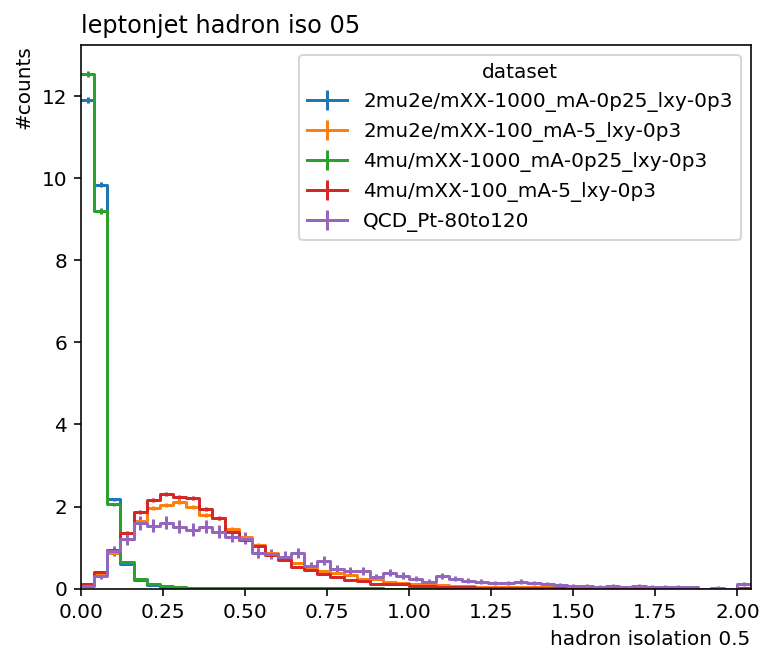

In [18]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['ljhadiso05'], overlay='dataset', ax=ax, overflow='over', density=True)
ax.set_title('leptonjet hadron iso 05', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

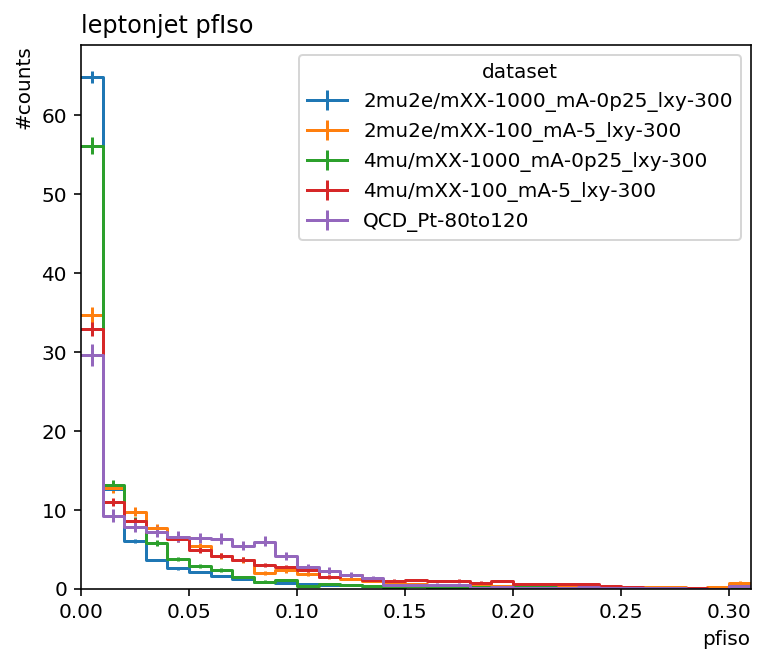

In [5]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['ljpfiso'], overlay='dataset', ax=ax, overflow='over', density=True)
ax.set_title('leptonjet pfIso', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

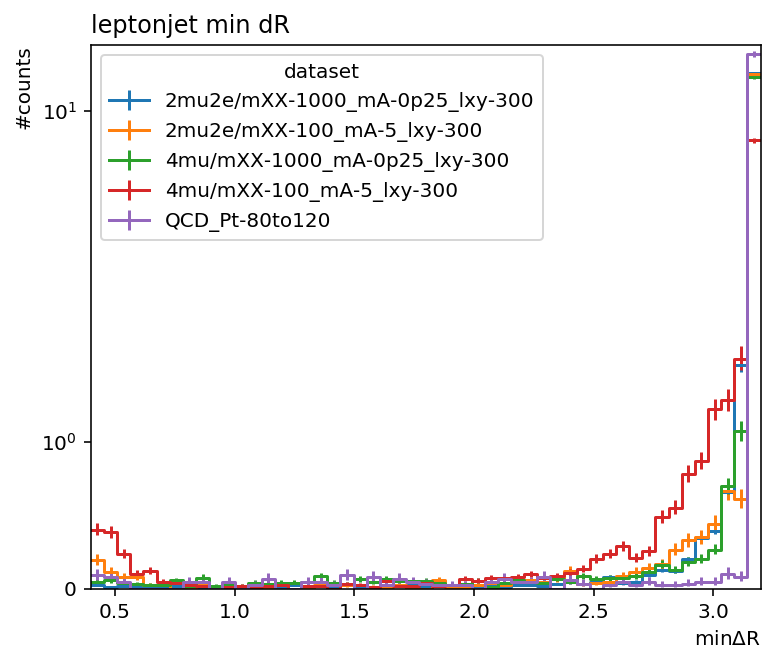

In [6]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['ljmindr'], overlay='dataset', ax=ax, overflow='over', density=True)
ax.set_yscale('symlog')
ax.set_title('leptonjet min dR', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## proximity wrt ak4chs

In [25]:
class myprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        mindr_axis = hist.Bin('mindr', 'min$\Delta$R', 50, 0, 5)
        njet_axis = hist.Bin('njet', 'njet', 5, 0, 5)
        pt_axis = hist.Bin('pt', '$p_T$ [GeV]', 25, 10, 110)
        self._accumulator = processor.dict_accumulator({
            'mindr': hist.Hist('Counts', dataset_axis, mindr_axis),
            'nlj': hist.Hist('Events', dataset_axis, njet_axis),
            'nak4': hist.Hist('Events', dataset_axis, njet_axis),
            'ak4pt': hist.Hist('Counts', dataset_axis, pt_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
        )
        ak4chs = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4chsNoLeptonjets_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['akjet_ak4chsNoLeptonjets_p4.fCoordinates.fX'],
                                                 df['akjet_ak4chsNoLeptonjets_p4.fCoordinates.fY'],
                                                 df['akjet_ak4chsNoLeptonjets_p4.fCoordinates.fZ'],
                                                 df['akjet_ak4chsNoLeptonjets_p4.fCoordinates.fT']),
            jetid=df['akjet_ak4chsNoLeptonjets_jetid'],
        )
        ak4chs = ak4chs[ak4chs.jetid&(ak4chs.pt>50)]
        
        output['nlj'].fill(dataset=dataset, njet=leptonjets.counts)
        output['nak4'].fill(dataset=dataset, njet=ak4chs.counts)
        output['ak4pt'].fill(dataset=dataset, pt=ak4chs.pt.flatten())
        
        pairs = leptonjets.p4.cross(ak4chs.p4, nested=True)
        mindr_ = pairs.i0.delta_r(pairs.i1)
        mindr = mindr_.min()
        
        output['mindr'].fill(dataset=dataset, mindr=mindr.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [26]:
dataset={
    'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 10/10 [00:03<00:00,  1.56items/s]


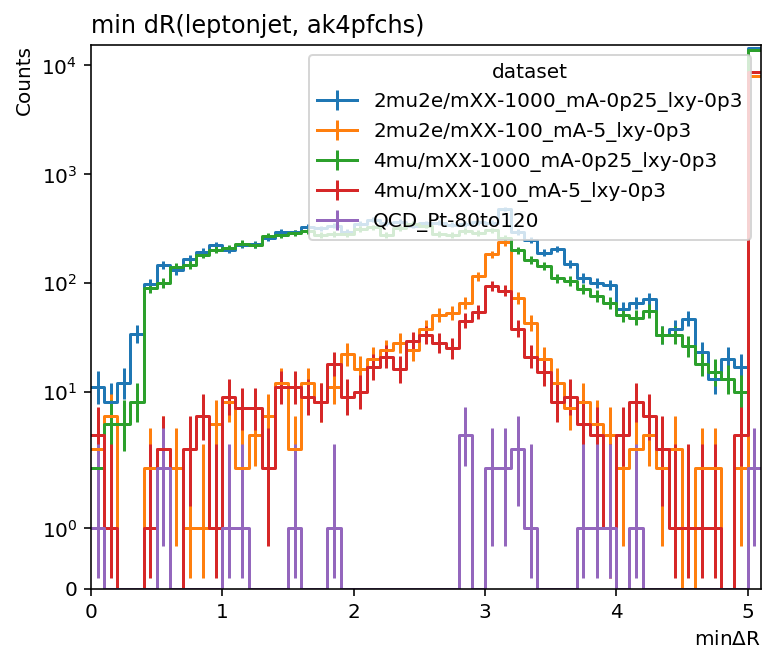

In [27]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['mindr'], overlay='dataset', ax=ax, overflow='over')
ax.set_yscale('symlog')
ax.set_title('min dR(leptonjet, ak4pfchs)', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

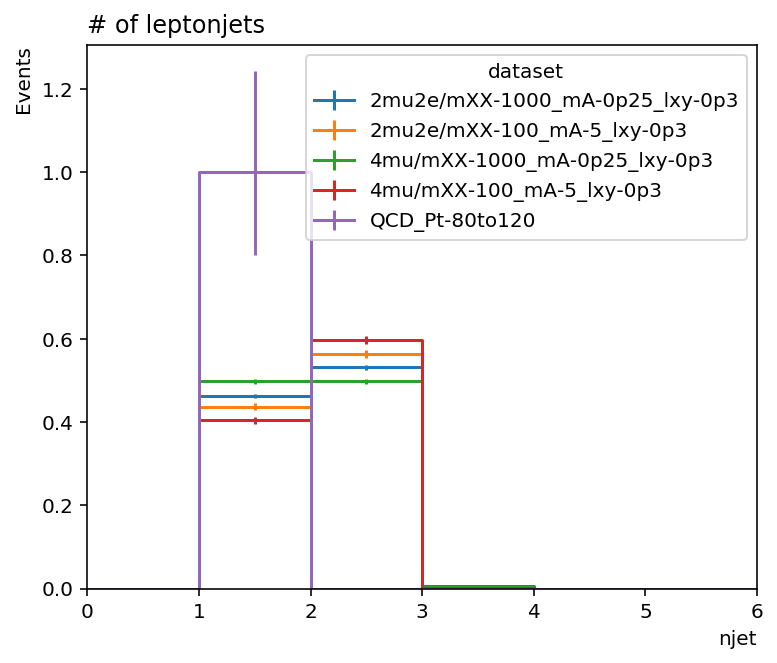

In [28]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['nlj'], overlay='dataset', ax=ax, overflow='over', density=True)
# ax.set_yscale('symlog')
ax.set_title('# of leptonjets', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

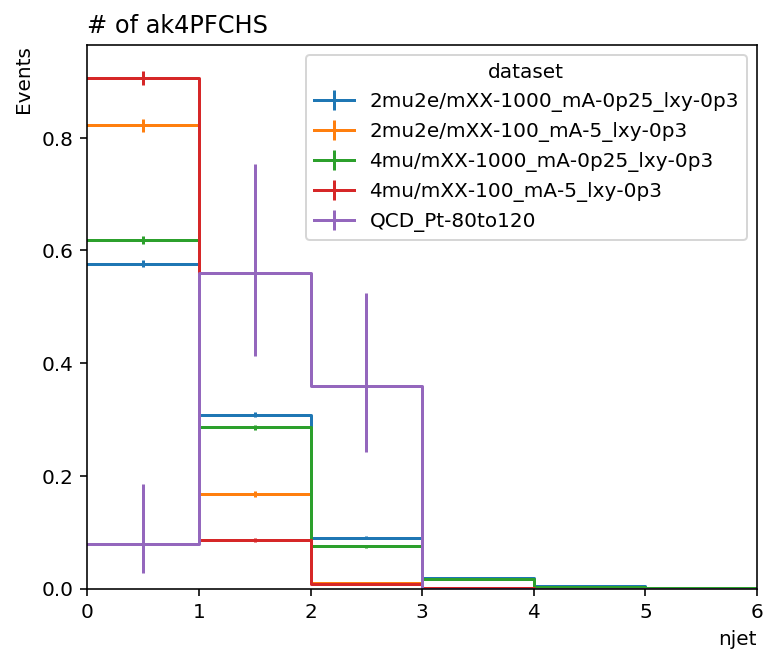

In [29]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['nak4'], overlay='dataset', ax=ax, overflow='over', density=True)
# ax.set_yscale('symlog')
ax.set_title('# of ak4PFCHS', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

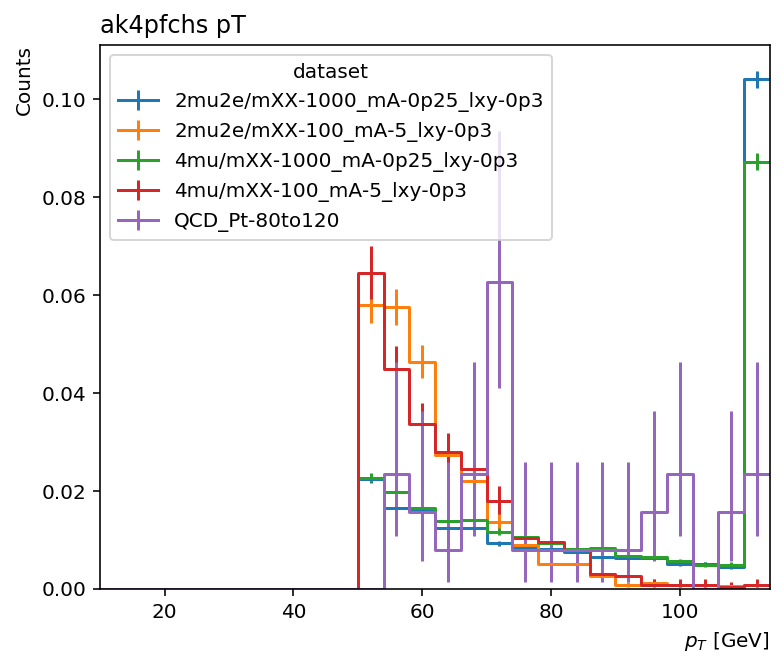

In [30]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['ak4pt'], overlay='dataset', ax=ax, overflow='over', density=True)
# ax.set_yscale('symlog')
ax.set_title('ak4pfchs pT', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## charge sum for mu type

In [17]:
class myprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        charge_axis = hist.Bin('chasum', '$\Sigma$charge', 5, -2, 3)
        self._accumulator = processor.dict_accumulator({
            'chasum': hist.Hist('Counts', dataset_axis, charge_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            p4=TLorentzVectorArray.from_cartesian(df['pfjet_p4.fCoordinates.fX'],
                                                 df['pfjet_p4.fCoordinates.fY'],
                                                 df['pfjet_p4.fCoordinates.fZ'],
                                                 df['pfjet_p4.fCoordinates.fT']),
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0),
                                  qsum=awkward.fromiter(df['pfjet_pfcand_charge']).sum())
        
        muljs = leptonjets[leptonjets.ismutype]
        output['chasum'].fill(dataset=dataset, chasum=muljs.qsum.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [14]:
dataset={
    'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 2/2 [00:02<00:00,  1.00s/items]


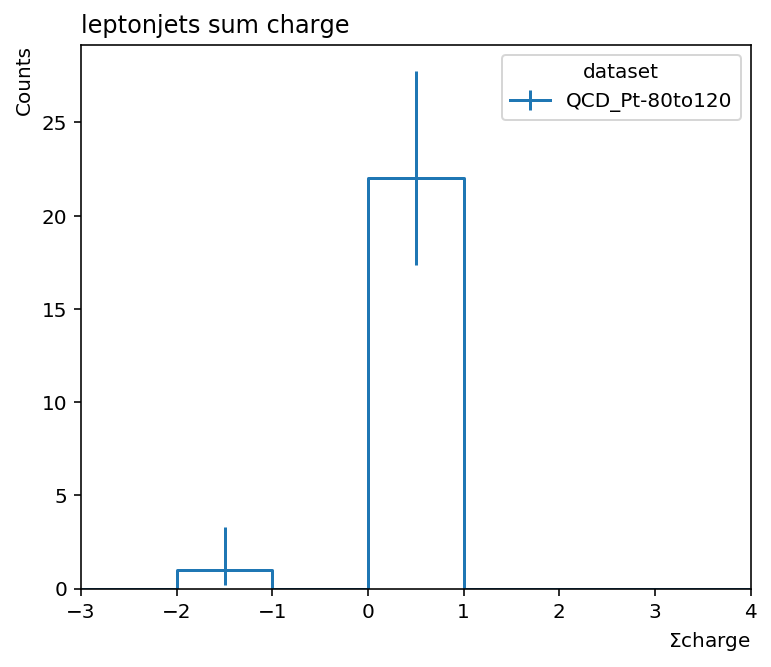

In [15]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
hist.plot1d(output['chasum'], overlay='dataset', ax=ax, overflow='all')
# ax.set_yscale('symlog')
ax.set_title('leptonjets sum charge', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## split by channel

In [3]:
ptbinning = np.concatenate([np.arange(0, 400, 10),
                           np.arange(400, 600, 20),
                           np.arange(600, 800, 50)])
massbinning = np.concatenate([np.arange(0, 0.5, 0.1),
                             np.arange(0.5, 10, 0.5)])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        order_axis = hist.Bin('order', 'order', 2, 0, 2)
        
        self._accumulator = processor.dict_accumulator({
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis, order_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis, order_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis, order_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis, order_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis, order_axis),
            'ljmdiff': hist.Hist("#counts", dataset_axis, mass_axis, channel_axis, ),
        })
#         self.pucorrs = get_pu_weights_function()
#         self.nlo_w = get_nlo_weight_function('w')
#         self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
#         wgts.add('genw', df['weight'])
        
#         nvtx = df['npv']
#         pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#         wgts.add('pileup', pu, puUp, puDown)
        
#         metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         wgts.add('metfilters', metfiltermask)

#         wnlo = np.ones_like(df.size)
#         if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#             genparticles = JaggedCandidateArray.candidatesfromcounts(
#                 df['gen_p4'],
#                 px=df['gen_p4.fCoordinates.fX'],
#                 py=df['gen_p4.fCoordinates.fY'],
#                 pz=df['gen_p4.fCoordinates.fZ'],
#                 energy=df['gen_p4.fCoordinates.fT'],
#                 pid=df['gen_pid'],
#             )
#             gentops = genparticles[np.abs(genparticles.pid)==6]
#             genws = genparticles[np.abs(genparticles.pid)==24]
#             genzs = genparticles[np.abs(genparticles.pid)==23]

#             if 'TTJets' in dataset:
#                 wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#             elif 'WJets' in dataset:
#                 wnlo = self.nlo_w(genws[0].p4.pt.sum())
#             elif 'DYJets' in dataset:
#                 wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#         wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
#         leptonjetpair = dileptonjets.distincts()
#         sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
#         if sumpt.size==0: return output
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu

#         leadingLjPair = leptonjetpair[sumpt.argmax()]
#         controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
#         leptonjets_ = dileptonjets[controlregion.flatten()]
#         wgt = wgt[controlregion.flatten()]
        leptonjets_ = dileptonjets

        
#         ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
#         ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljpt'].fill(dataset=dataset, pt=lj0.pt.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljeta'].fill(dataset=dataset, eta=lj0.eta.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljphi'].fill(dataset=dataset, phi=lj0.phi.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljmass'].fill(dataset=dataset, mass=lj0.mass.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljqsum'].fill(dataset=dataset, qsum=lj0.qsum.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        
        output['ljpt'].fill(dataset=dataset, pt=lj1.pt.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljeta'].fill(dataset=dataset, eta=lj1.eta.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljphi'].fill(dataset=dataset, phi=lj1.phi.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljmass'].fill(dataset=dataset, mass=lj1.mass.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljqsum'].fill(dataset=dataset, qsum=lj1.qsum.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))

        output['ljmdiff'].fill(dataset=dataset, mass=np.abs(lj0.mass-lj1.mass).flatten(), channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
#         origidentity = list(accumulator)        
#         for k in origidentity:
#             accumulator[k].scale(scales, axis='dataset')
#             accumulator[k+'_cat'] = accumulator[k].group("dataset",
#                                                          hist.Cat("cat", "datasets"),
#                                                          mapping)
        return accumulator

In [4]:
dataset={
#     'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 8/8 [00:04<00:00,  1.29items/s]


In [5]:
def makeplot2(key, text, overflow='over', logy=True):
    fig, axes =plt.subplots(2,2,figsize=(16,12))
    hist.plot1d(output[key].sum('label').integrate('order', slice(0,1)).integrate('channel', slice(1,2))
                , ax=axes[0][0], overlay='dataset', overflow=overflow, )
    axes[0][0].set_title(f'[all region|2mu2e] leading leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].sum('label').integrate('order', slice(1,2)).integrate('channel', slice(1,2))
                , overlay='dataset', ax=axes[0][1], overflow=overflow, )
    axes[0][1].set_title(f'[all region|2mu2e] subleading leptonJets {text}', x=0.0, ha="left")


    hist.plot1d(output[key].sum('label').integrate('order', slice(0,1)).integrate('channel', slice(2,3))
                , overlay='dataset', ax=axes[1][0], overflow=overflow, )
    axes[1][0].set_title(f'[all region|4mu] leading leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].sum('label').integrate('order', slice(1,2)).integrate('channel', slice(2,3))
                , overlay='dataset', ax=axes[1][1], overflow=overflow, )
    axes[1][1].set_title(f'[all region|4mu] subleading leptonJets {text}', x=0.0, ha="left")


    for ax in axes.flat:
#         ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

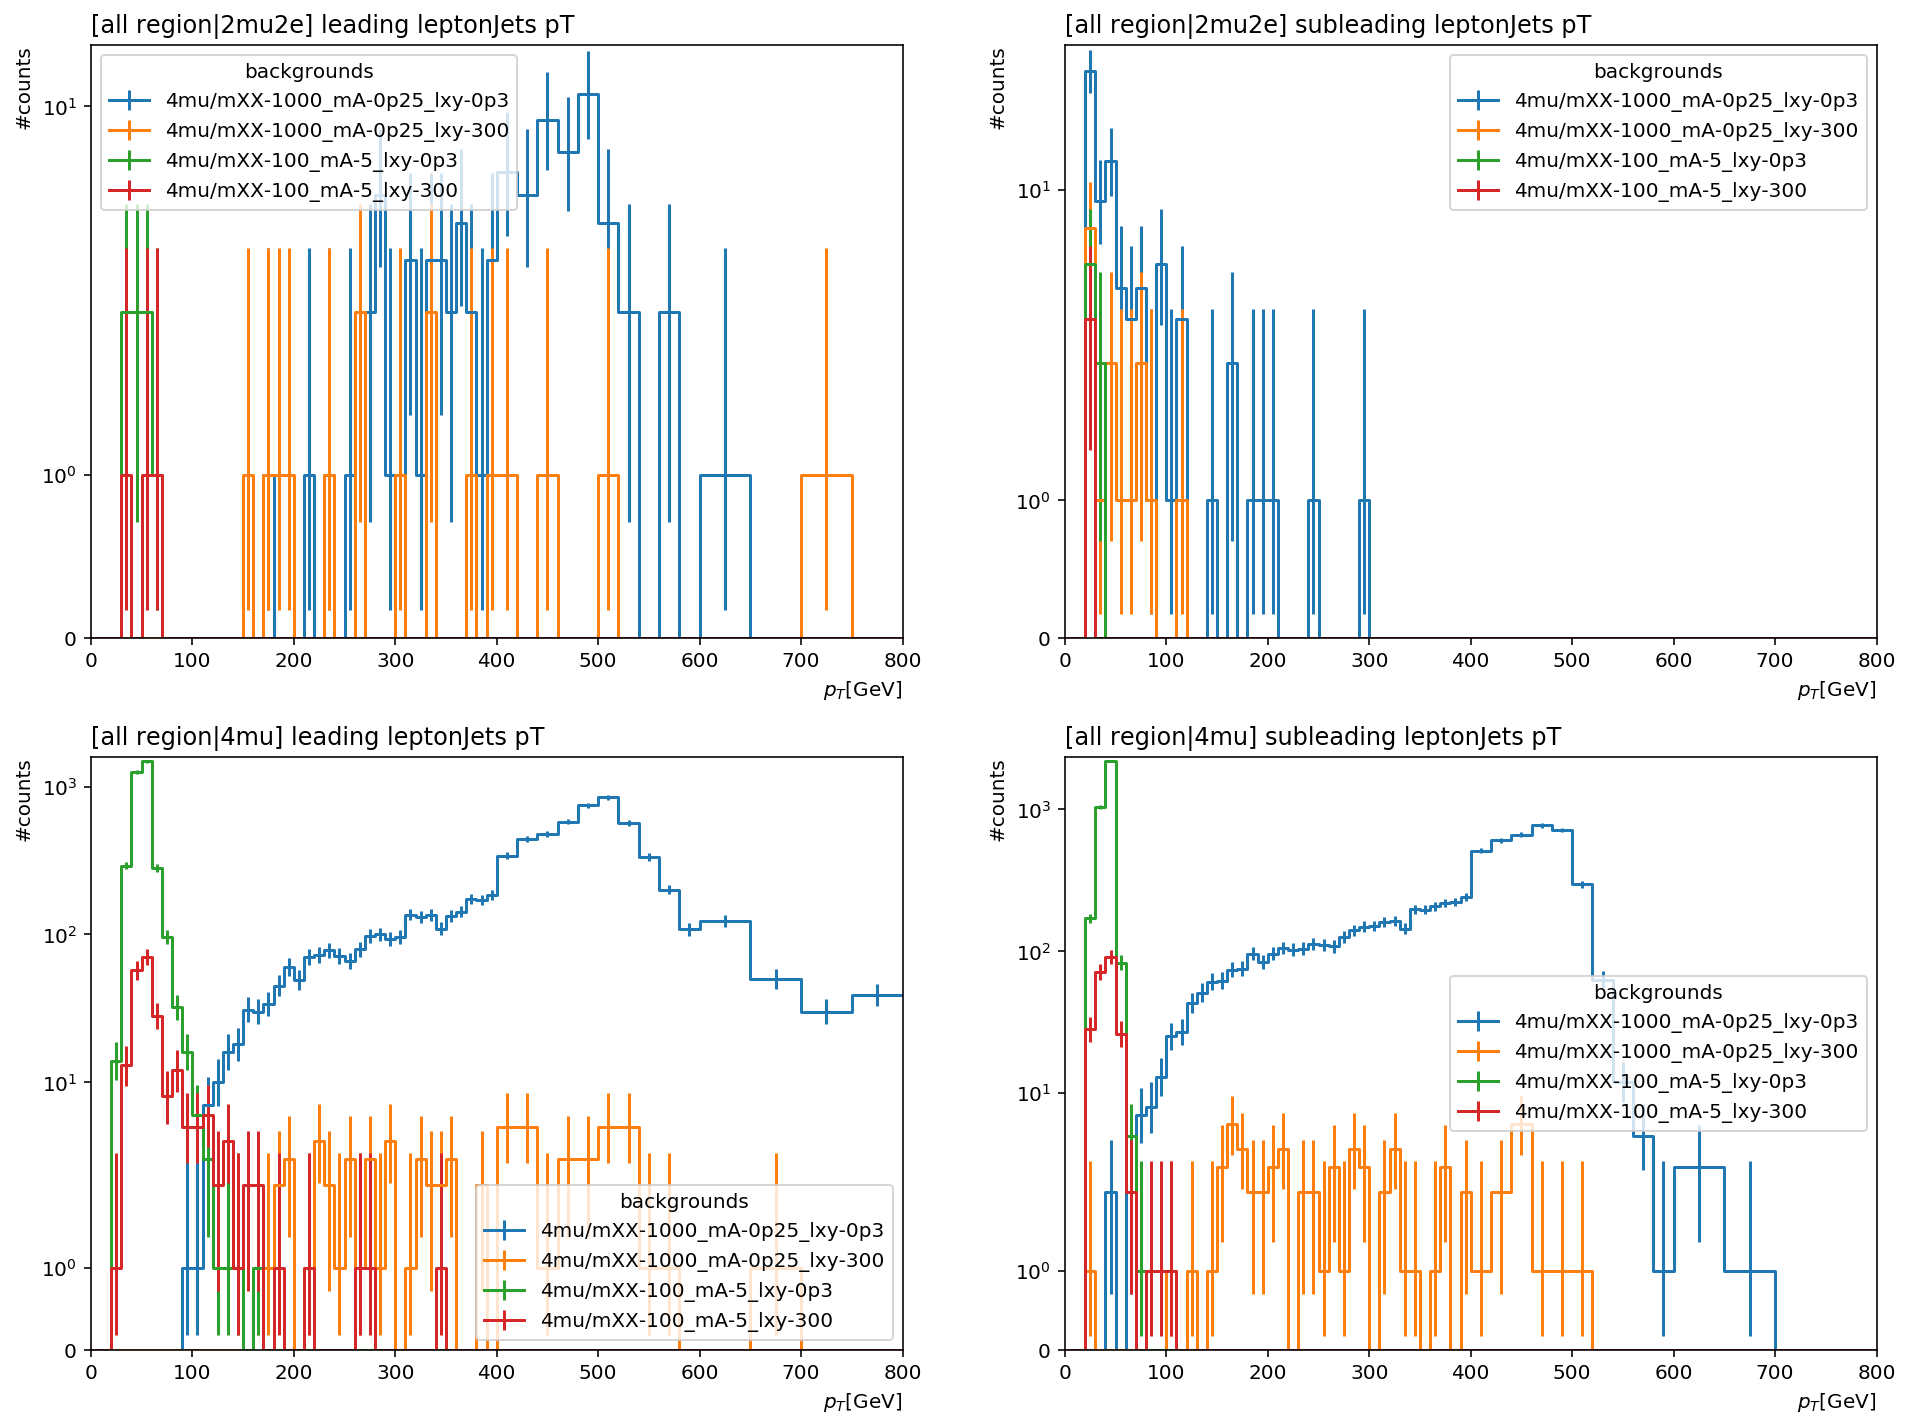

In [7]:
makeplot2('ljpt', 'pT')

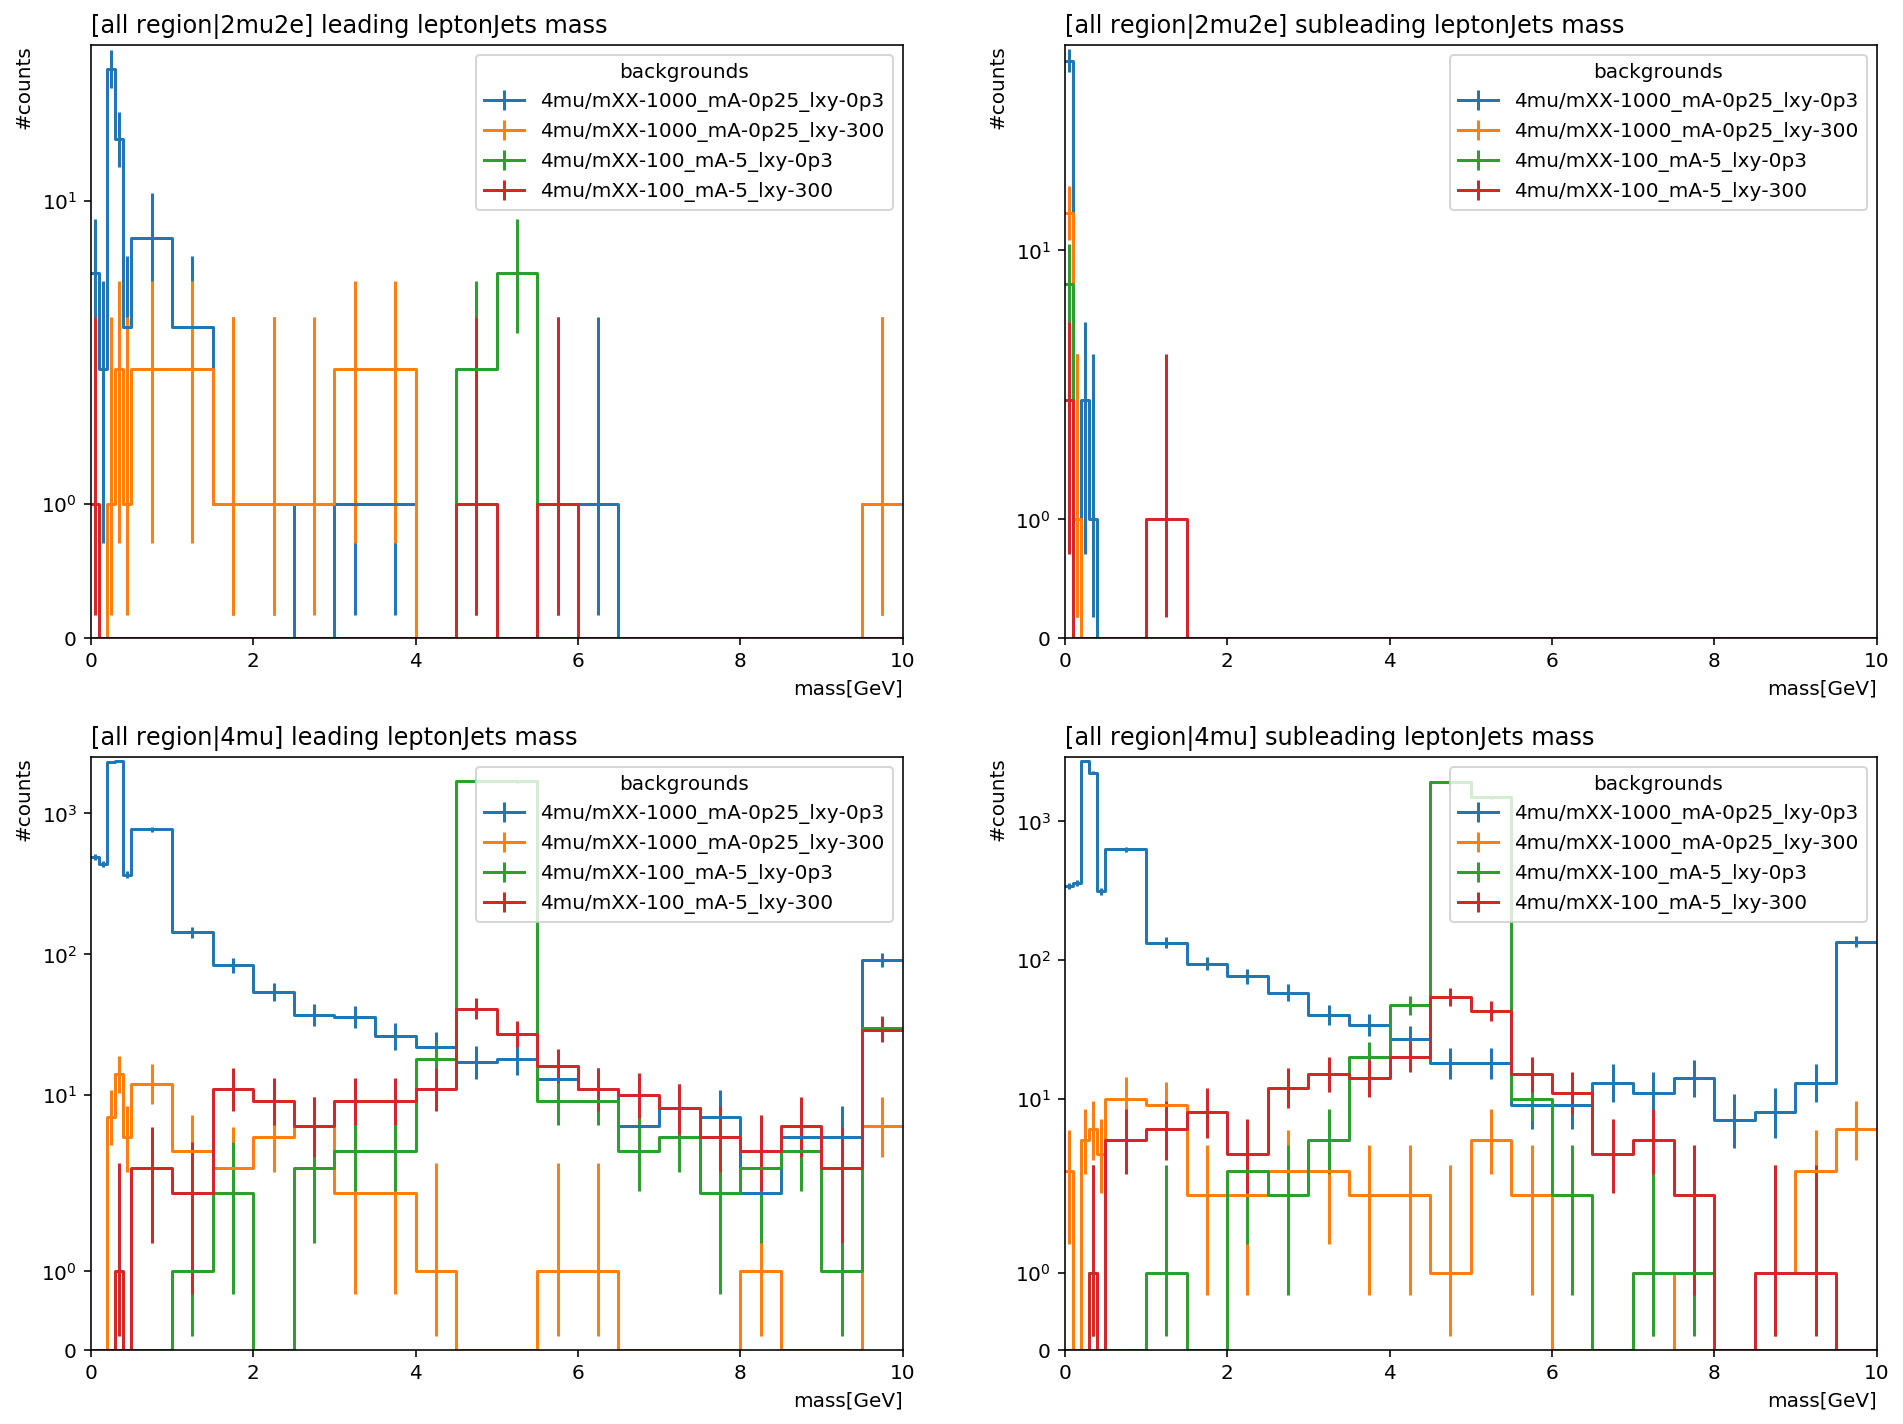

In [13]:
makeplot2('ljmass', 'mass', overflow='over')

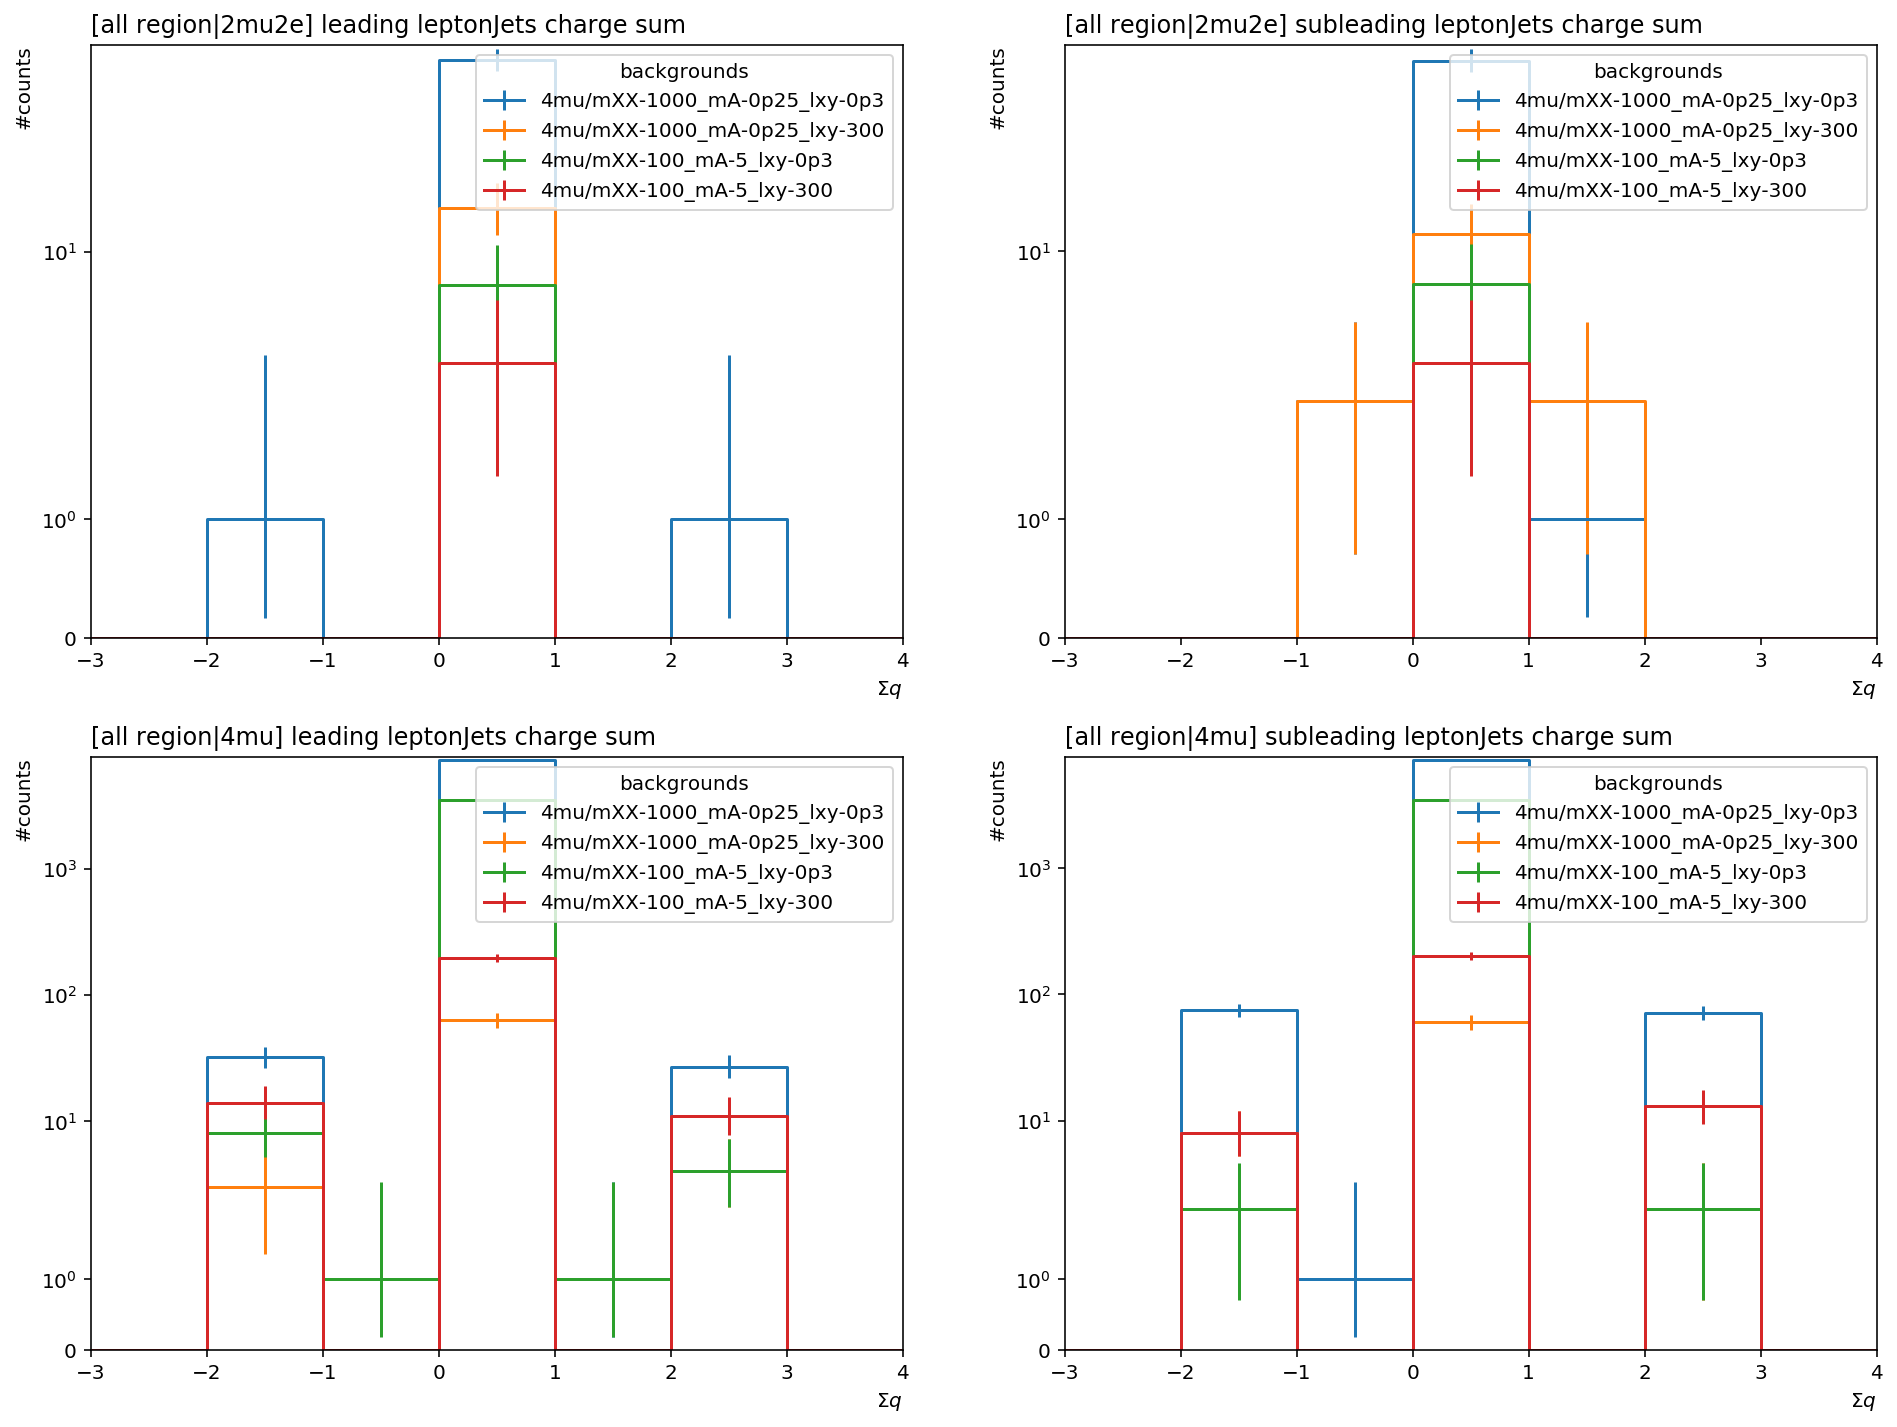

In [6]:
makeplot2('ljqsum', 'charge sum', overflow='all')

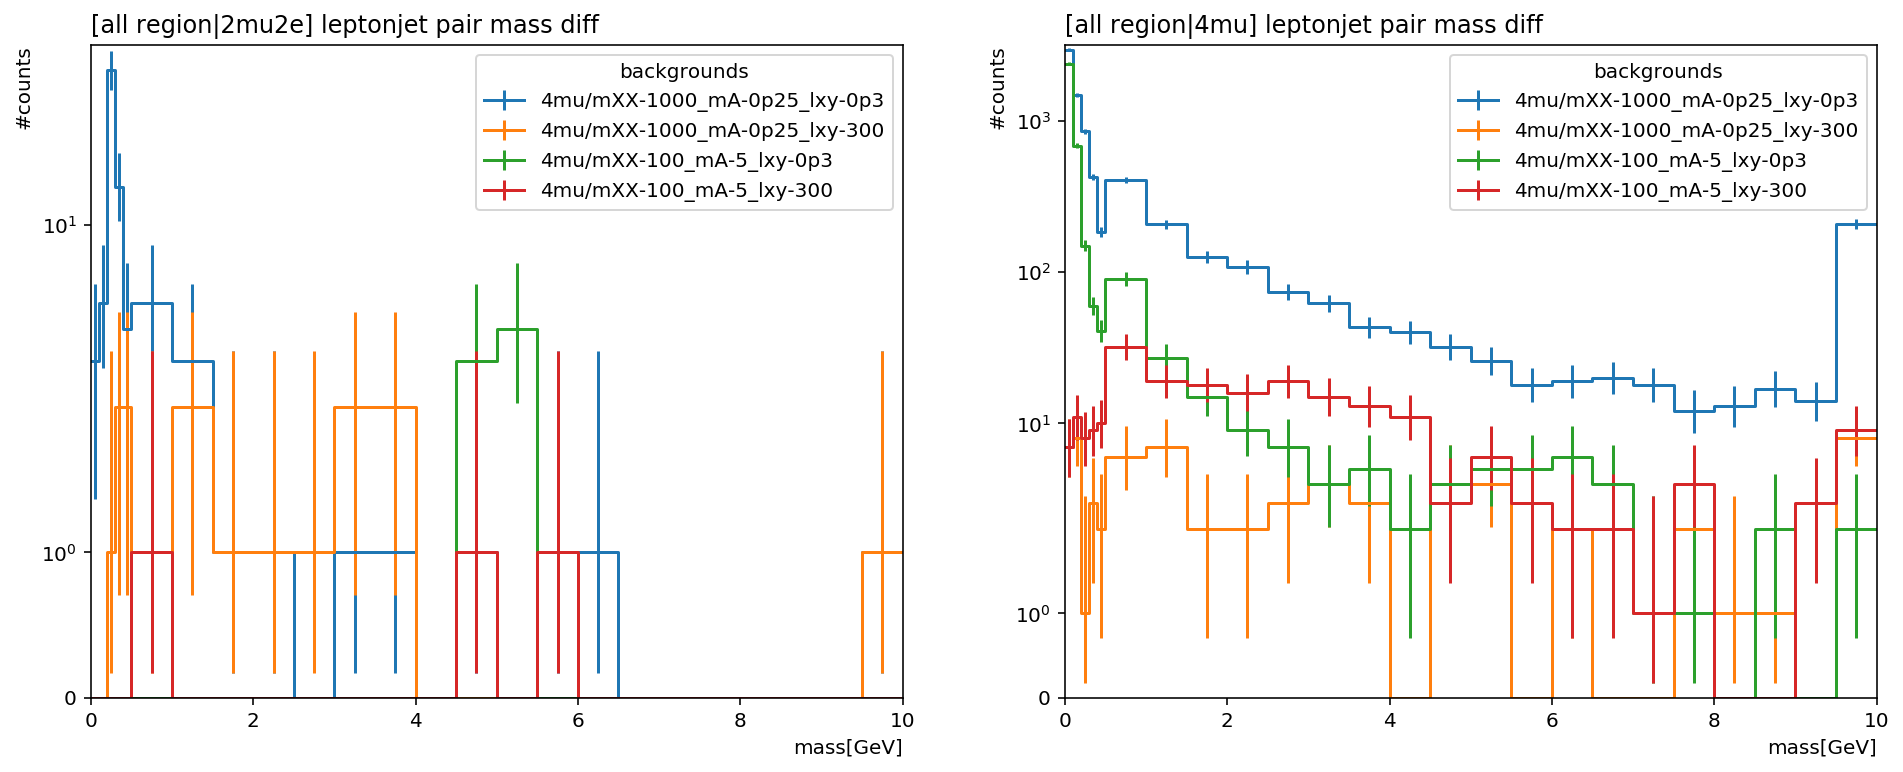

In [22]:
fig,axes=plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ljmdiff'].integrate('channel', slice(1,2)), ax=axes[0], overlay='dataset', overflow='over')
axes[0].set_title('[all region|2mu2e] leptonjet pair mass diff', x=0, ha='left')
hist.plot1d(output['ljmdiff'].integrate('channel', slice(2,3)), ax=axes[1], overlay='dataset', overflow='over')
axes[1].set_title('[all region|4mu] leptonjet pair mass diff', x=0, ha='left')
for ax in axes.flat:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [23]:
dataset={
#     'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 8/8 [00:03<00:00,  1.33items/s]


/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


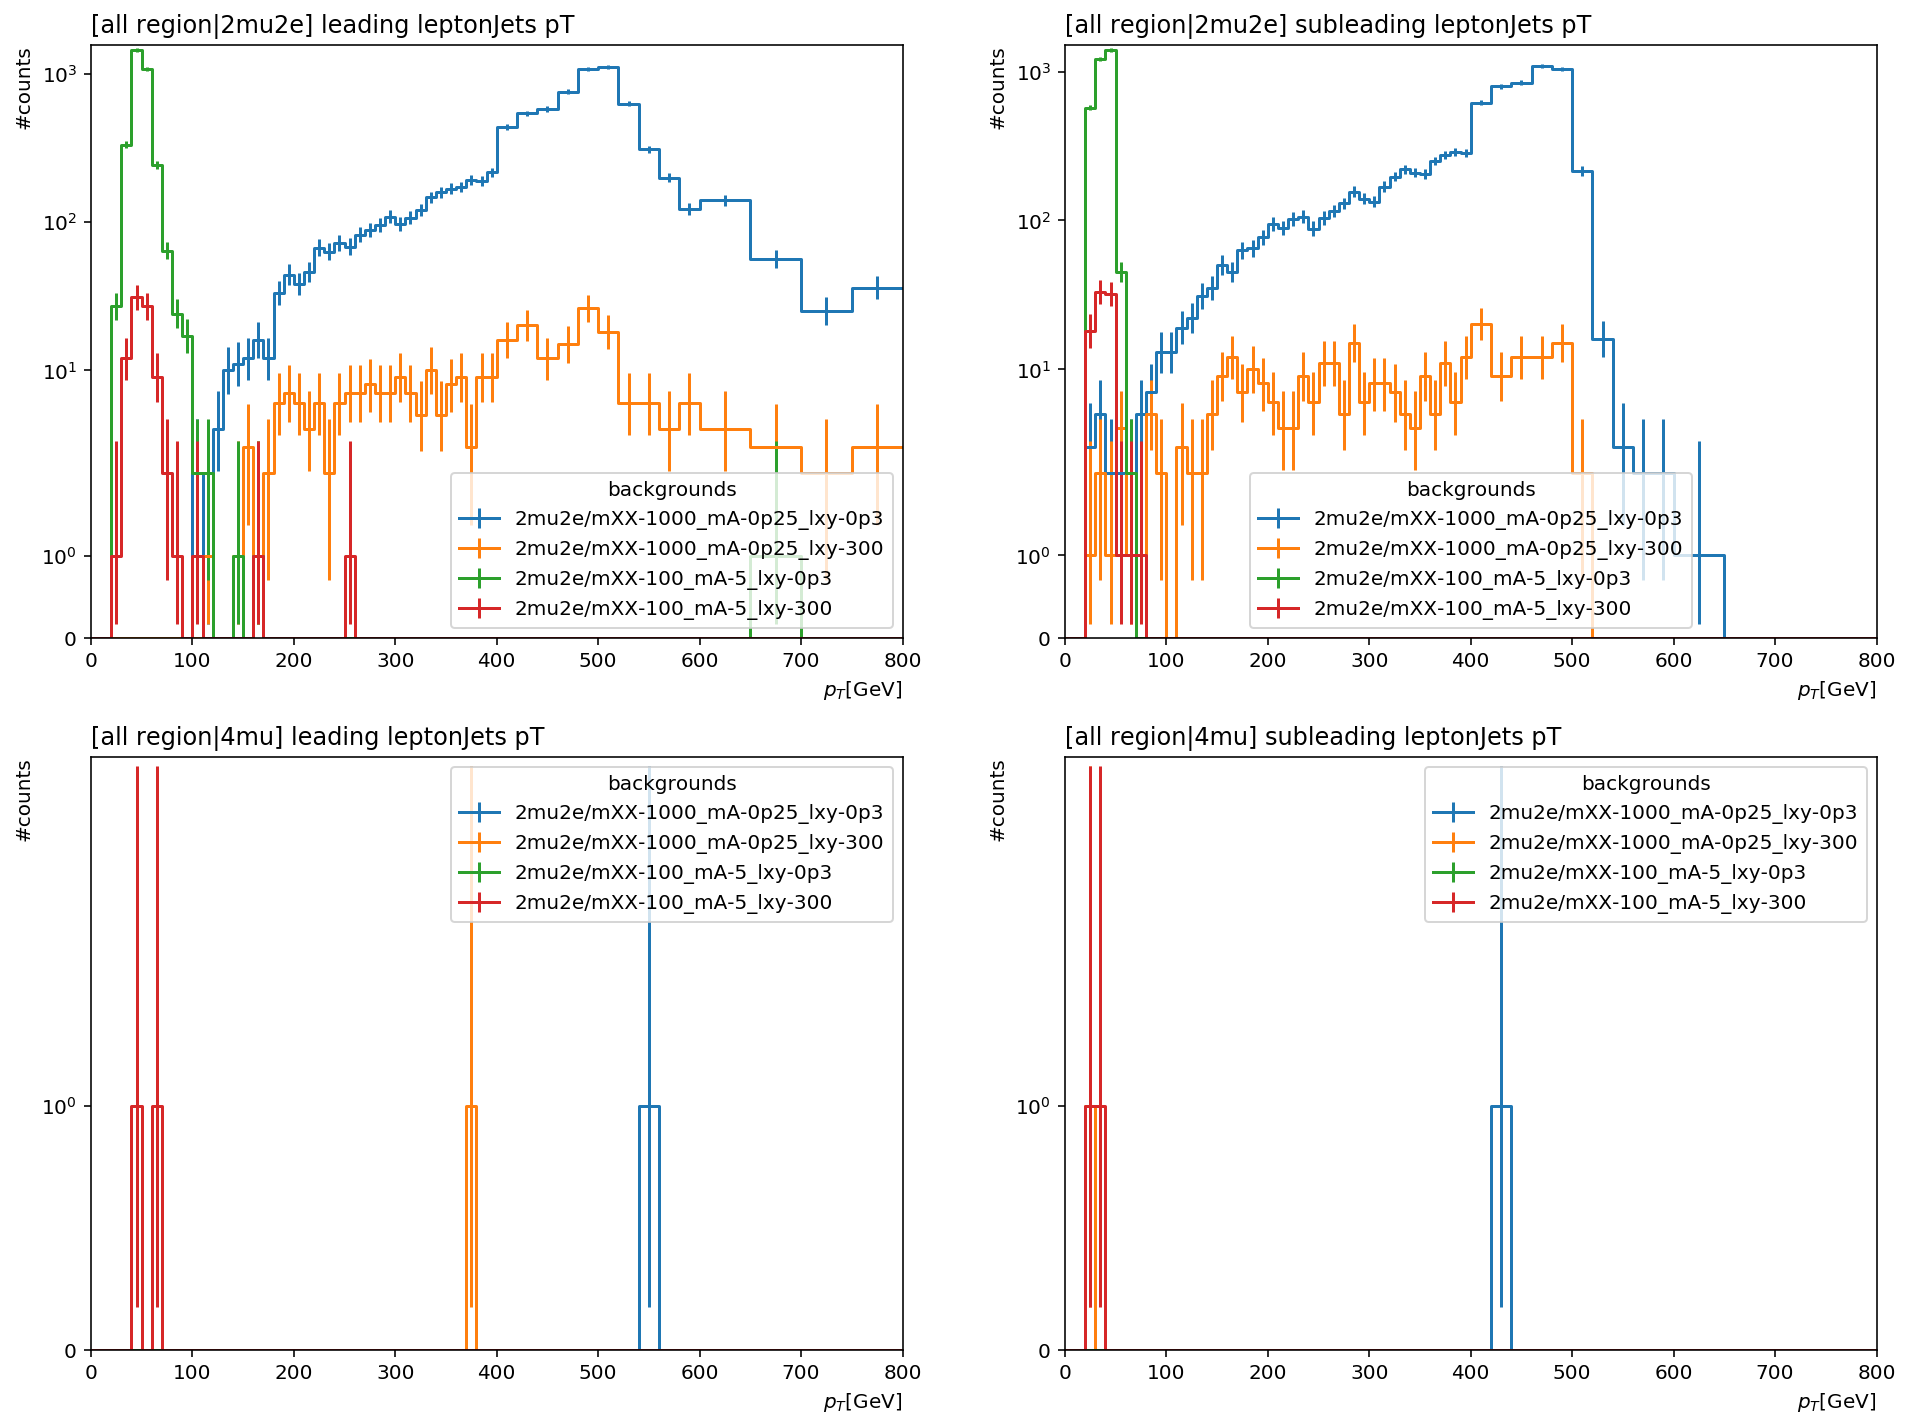

In [15]:
makeplot2('ljpt', 'pT')

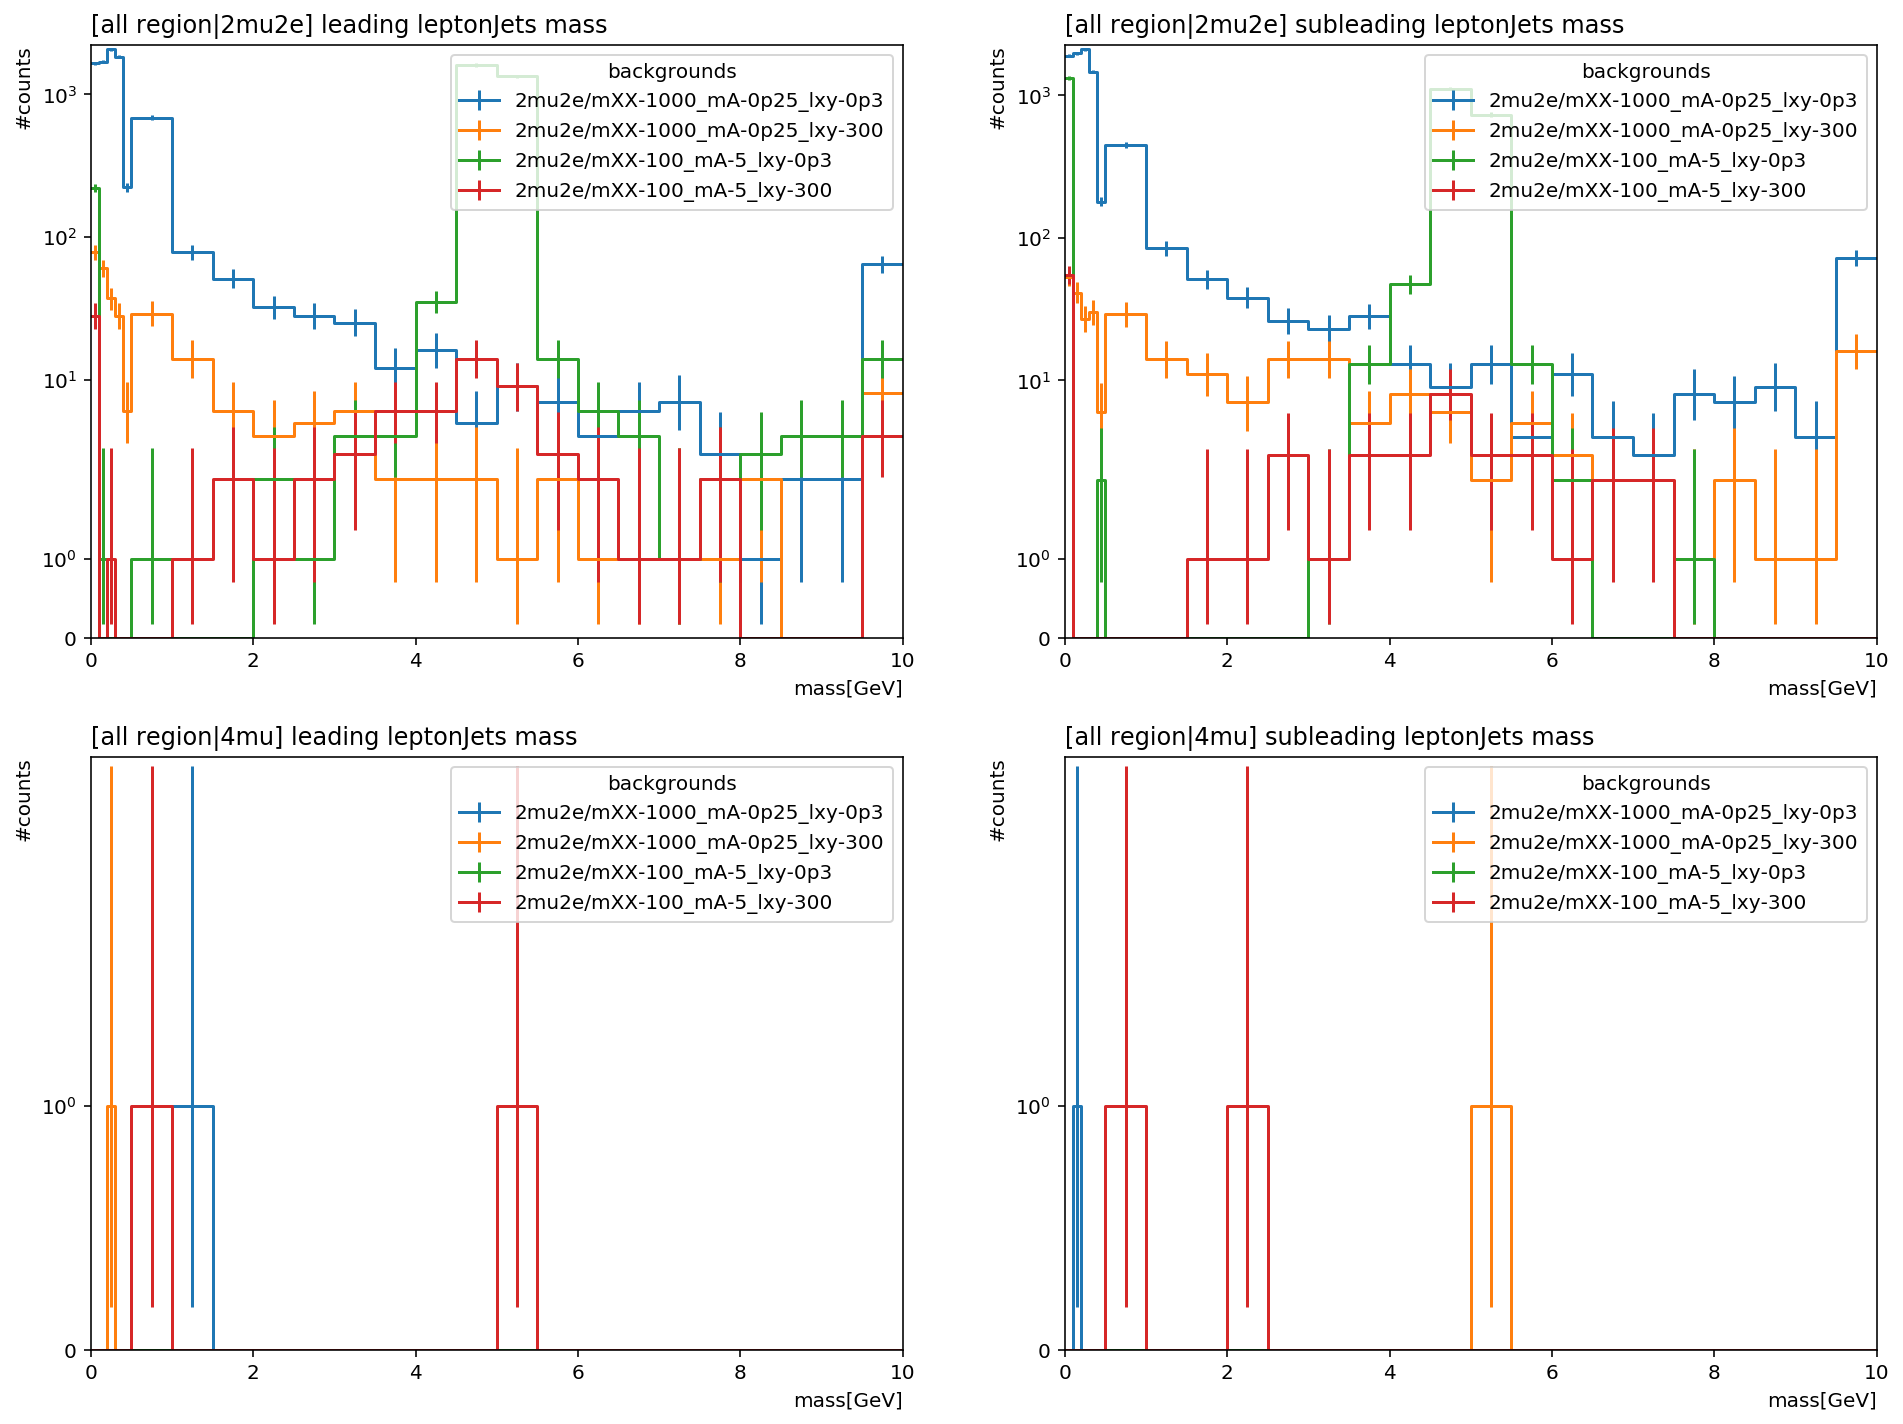

In [16]:
makeplot2('ljmass', 'mass', overflow='over')

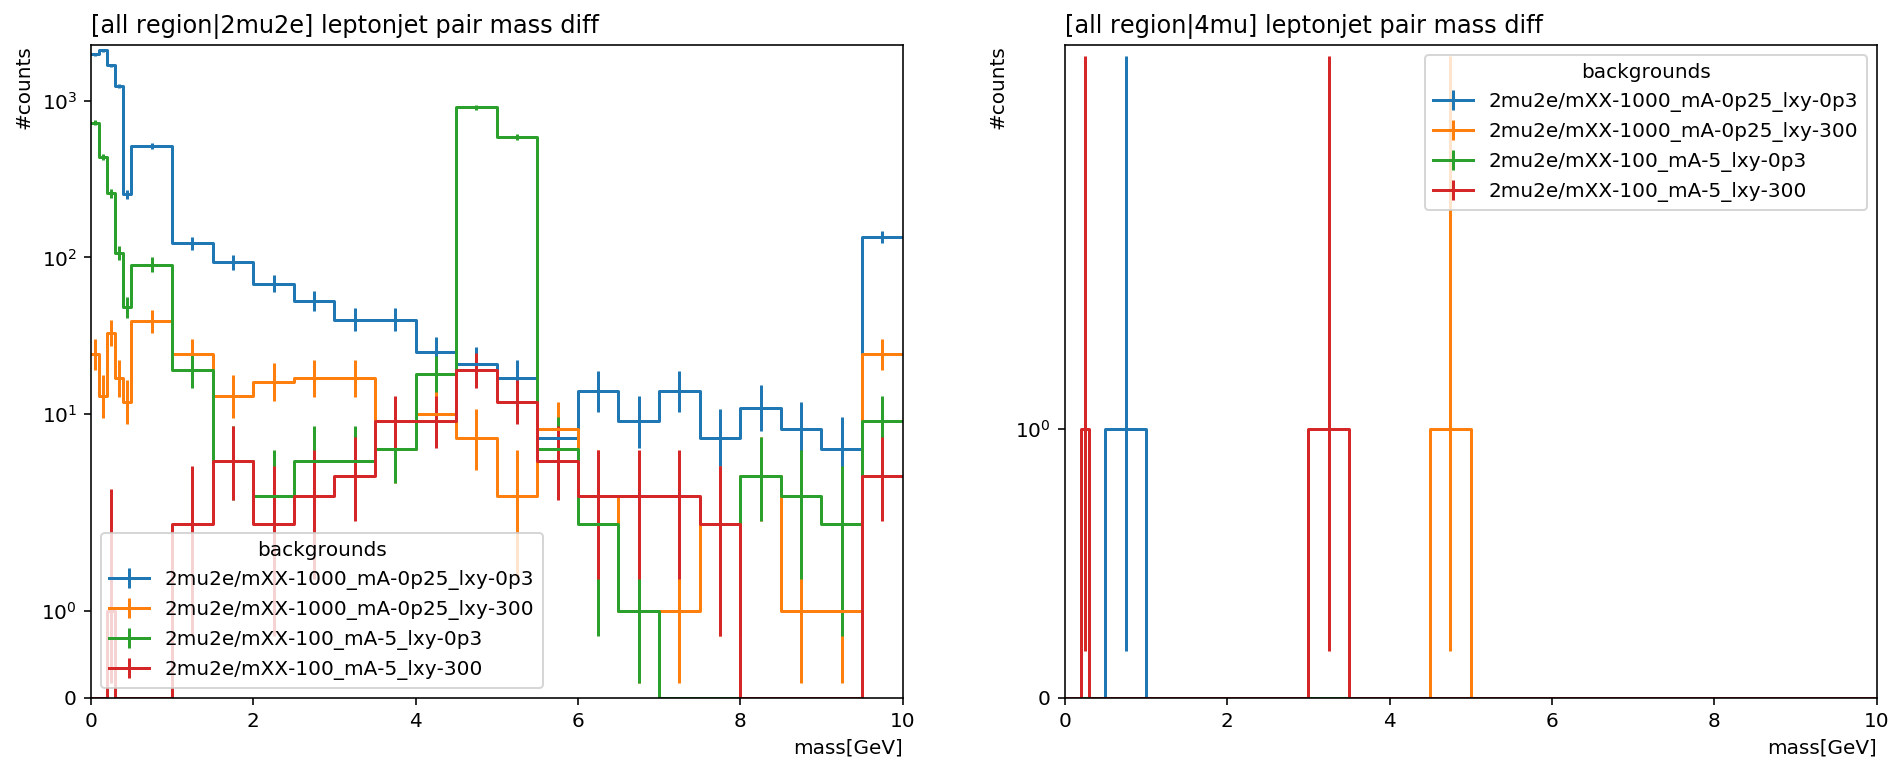

In [24]:
fig,axes=plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ljmdiff'].integrate('channel', slice(1,2)), ax=axes[0], overlay='dataset', overflow='over')
axes[0].set_title('[all region|2mu2e] leptonjet pair mass diff', x=0, ha='left')
hist.plot1d(output['ljmdiff'].integrate('channel', slice(2,3)), ax=axes[1], overlay='dataset', overflow='over')
axes[1].set_title('[all region|4mu] leptonjet pair mass diff', x=0, ha='left')
for ax in axes.flat:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

# split by channel/type

In [8]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
        })
 
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu

        leptonjets_ = dileptonjets

        
       
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
       
        output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), channel=ljchannel)
         
        return output
    
    def postprocess(self, accumulator):

        return accumulator

In [9]:
dataset={
#     'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
#     '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
#     '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
#     '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 8/8 [00:03<00:00,  1.55items/s]


In [10]:
def makeplot(key, text, overflow='over', logy=True, density=True):
    fig, axes =plt.subplots(2,3,figsize=(24,12))
    hist.plot1d(output[key].integrate('label', slice(1,2)).integrate('channel', slice(1,2))
                , overlay='dataset', ax=axes[0][0], overflow=overflow, density=density )
    axes[0][0].set_title(f'[all region|2mu2e] egamma-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(2,3)).integrate('channel', slice(1,2))
                , overlay='dataset', ax=axes[0][1], overflow=overflow, density=density)
    axes[0][1].set_title(f'[all region|2mu2e] pfmu-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(3,4)).integrate('channel', slice(1,2))
                , overlay='dataset', ax=axes[0][2], overflow=overflow, density=density)
    axes[0][2].set_title(f'[all region|2mu2e] dsamu-type leptonJets {text}', x=0.0, ha="left")

    hist.plot1d(output[key].integrate('label', slice(1,2)).integrate('channel', slice(2,3))
                , overlay='dataset', ax=axes[1][0], overflow=overflow, density=density)
    axes[1][0].set_title(f'[all region|4mu] egamma-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(2,3)).integrate('channel', slice(2,3))
                , overlay='dataset', ax=axes[1][1], overflow=overflow, density=density)
    axes[1][1].set_title(f'[all region|4mu] pfmu-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(3,4)).integrate('channel', slice(2,3))
                , overlay='dataset', ax=axes[1][2], overflow=overflow, density=density)
    axes[1][2].set_title(f'[all region|4mu] dsamu-type leptonJets {text}', x=0.0, ha="left")

    for ax in axes.flat:
#         ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


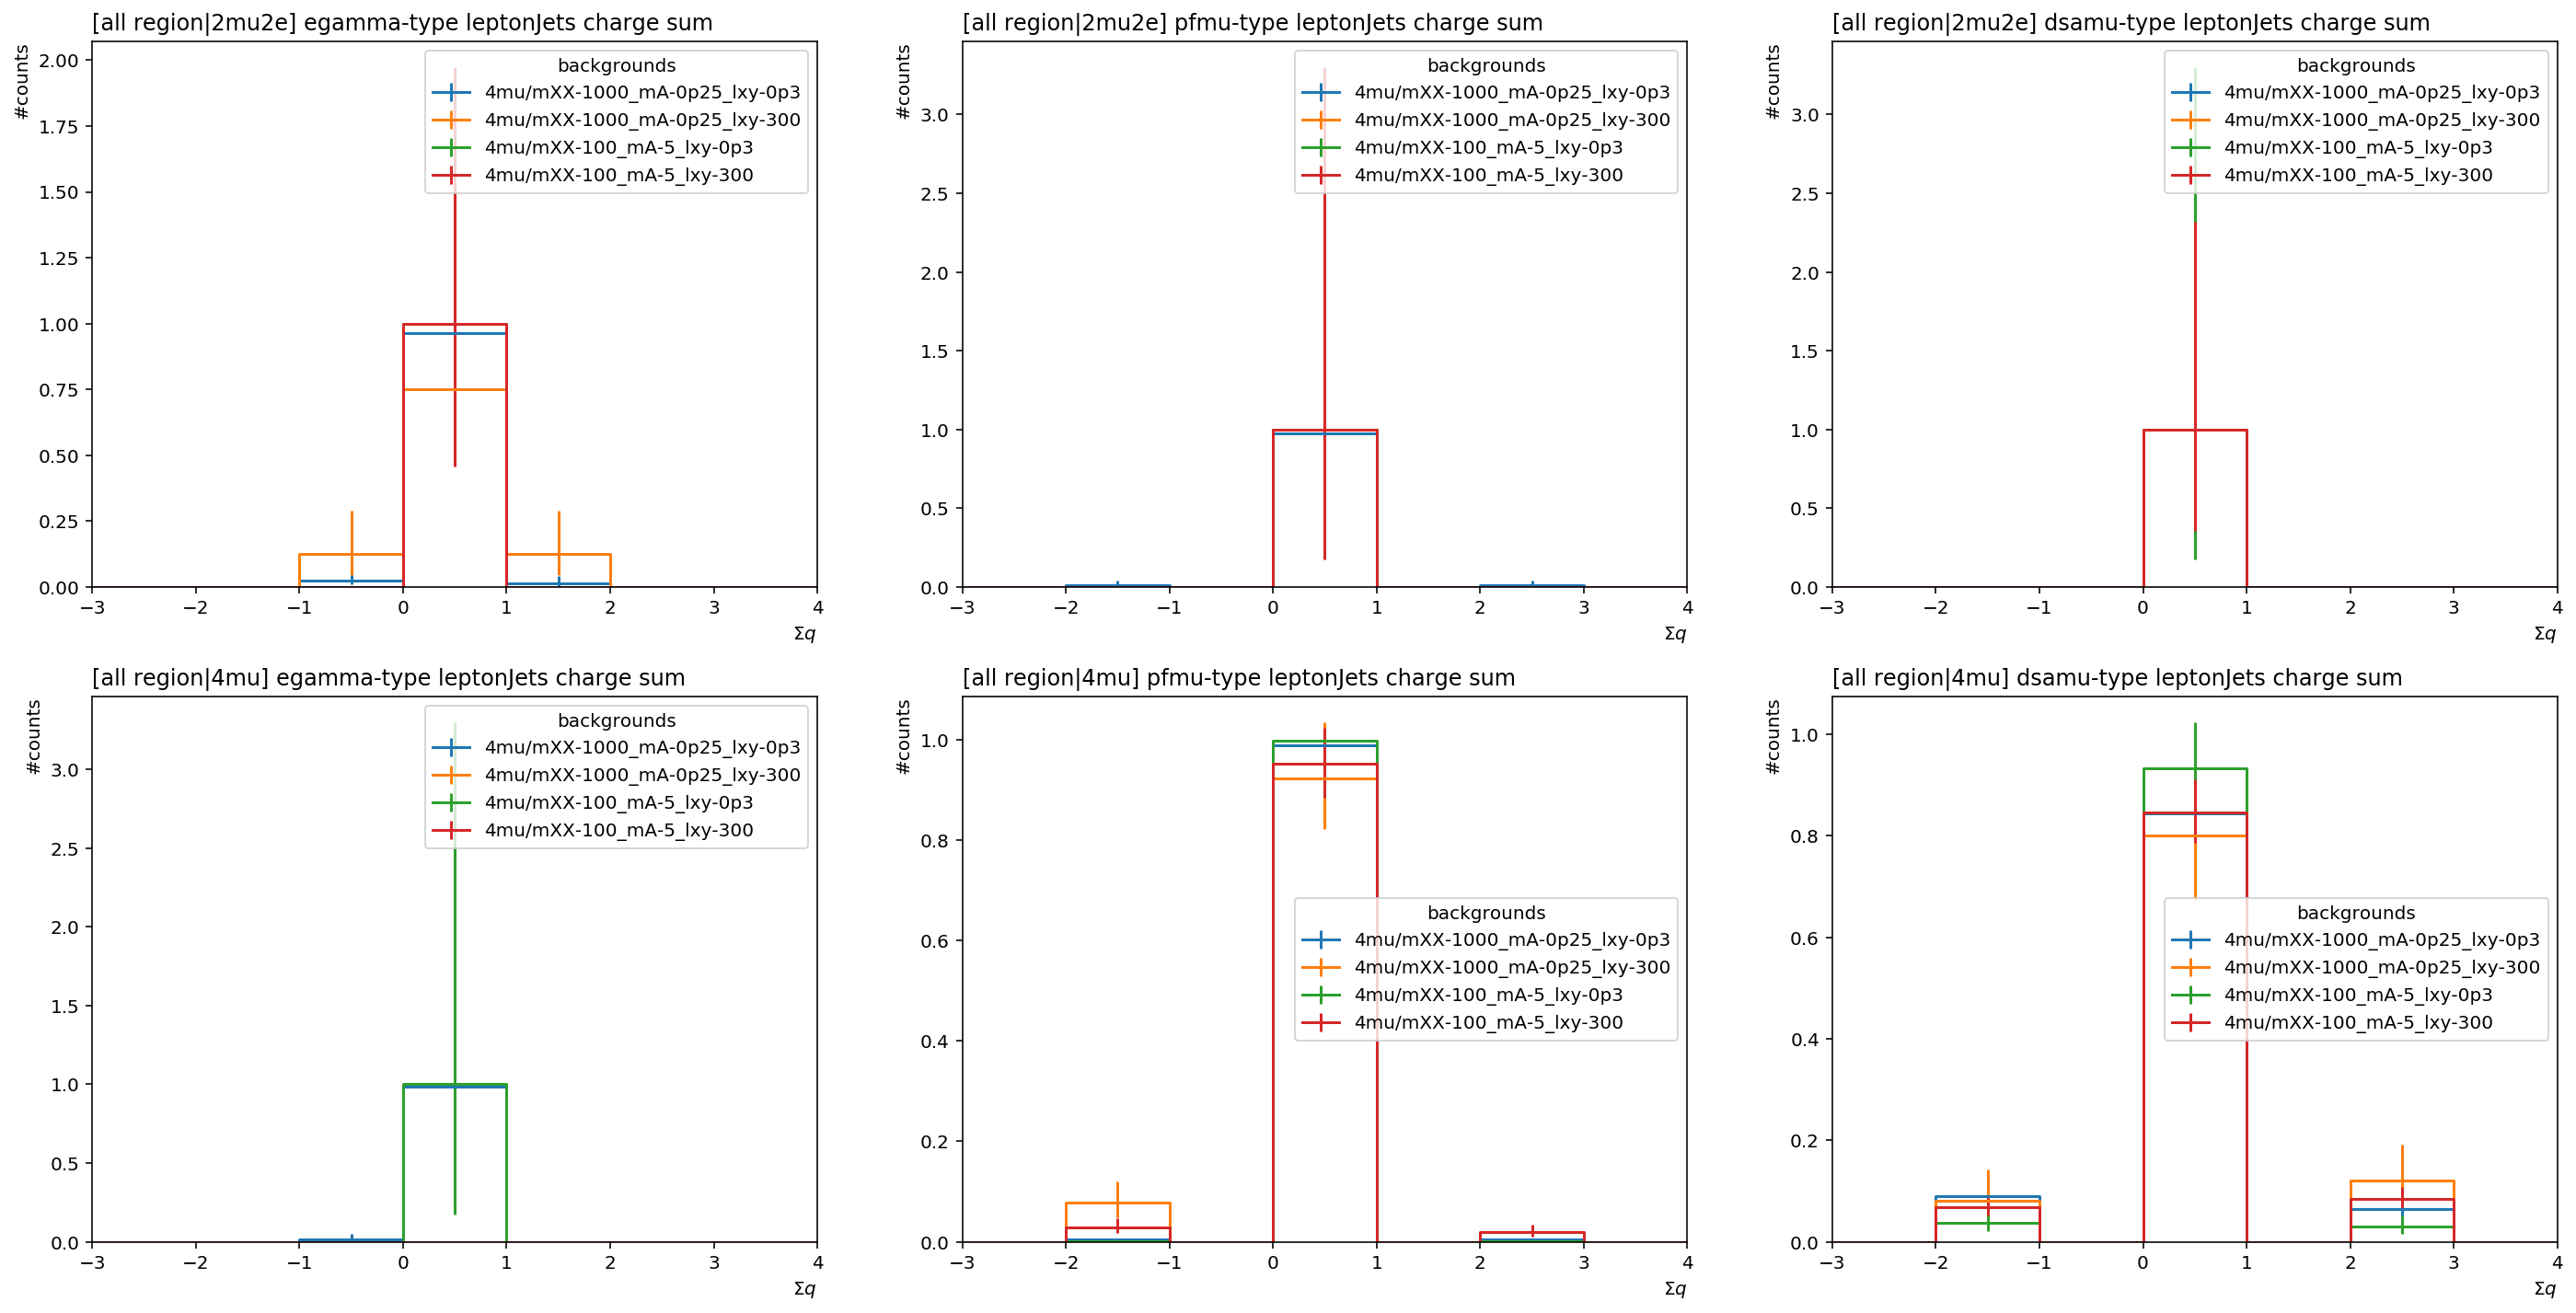

In [11]:
makeplot('ljqsum', 'charge sum', overflow='all', logy=False)

In [12]:
dataset={
#     'QCD_Pt-80to120': backgrounds_['QCD']['QCD_Pt-80to120'],
#     '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
#     '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
#     '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
#     '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 8/8 [00:04<00:00,  2.00items/s]


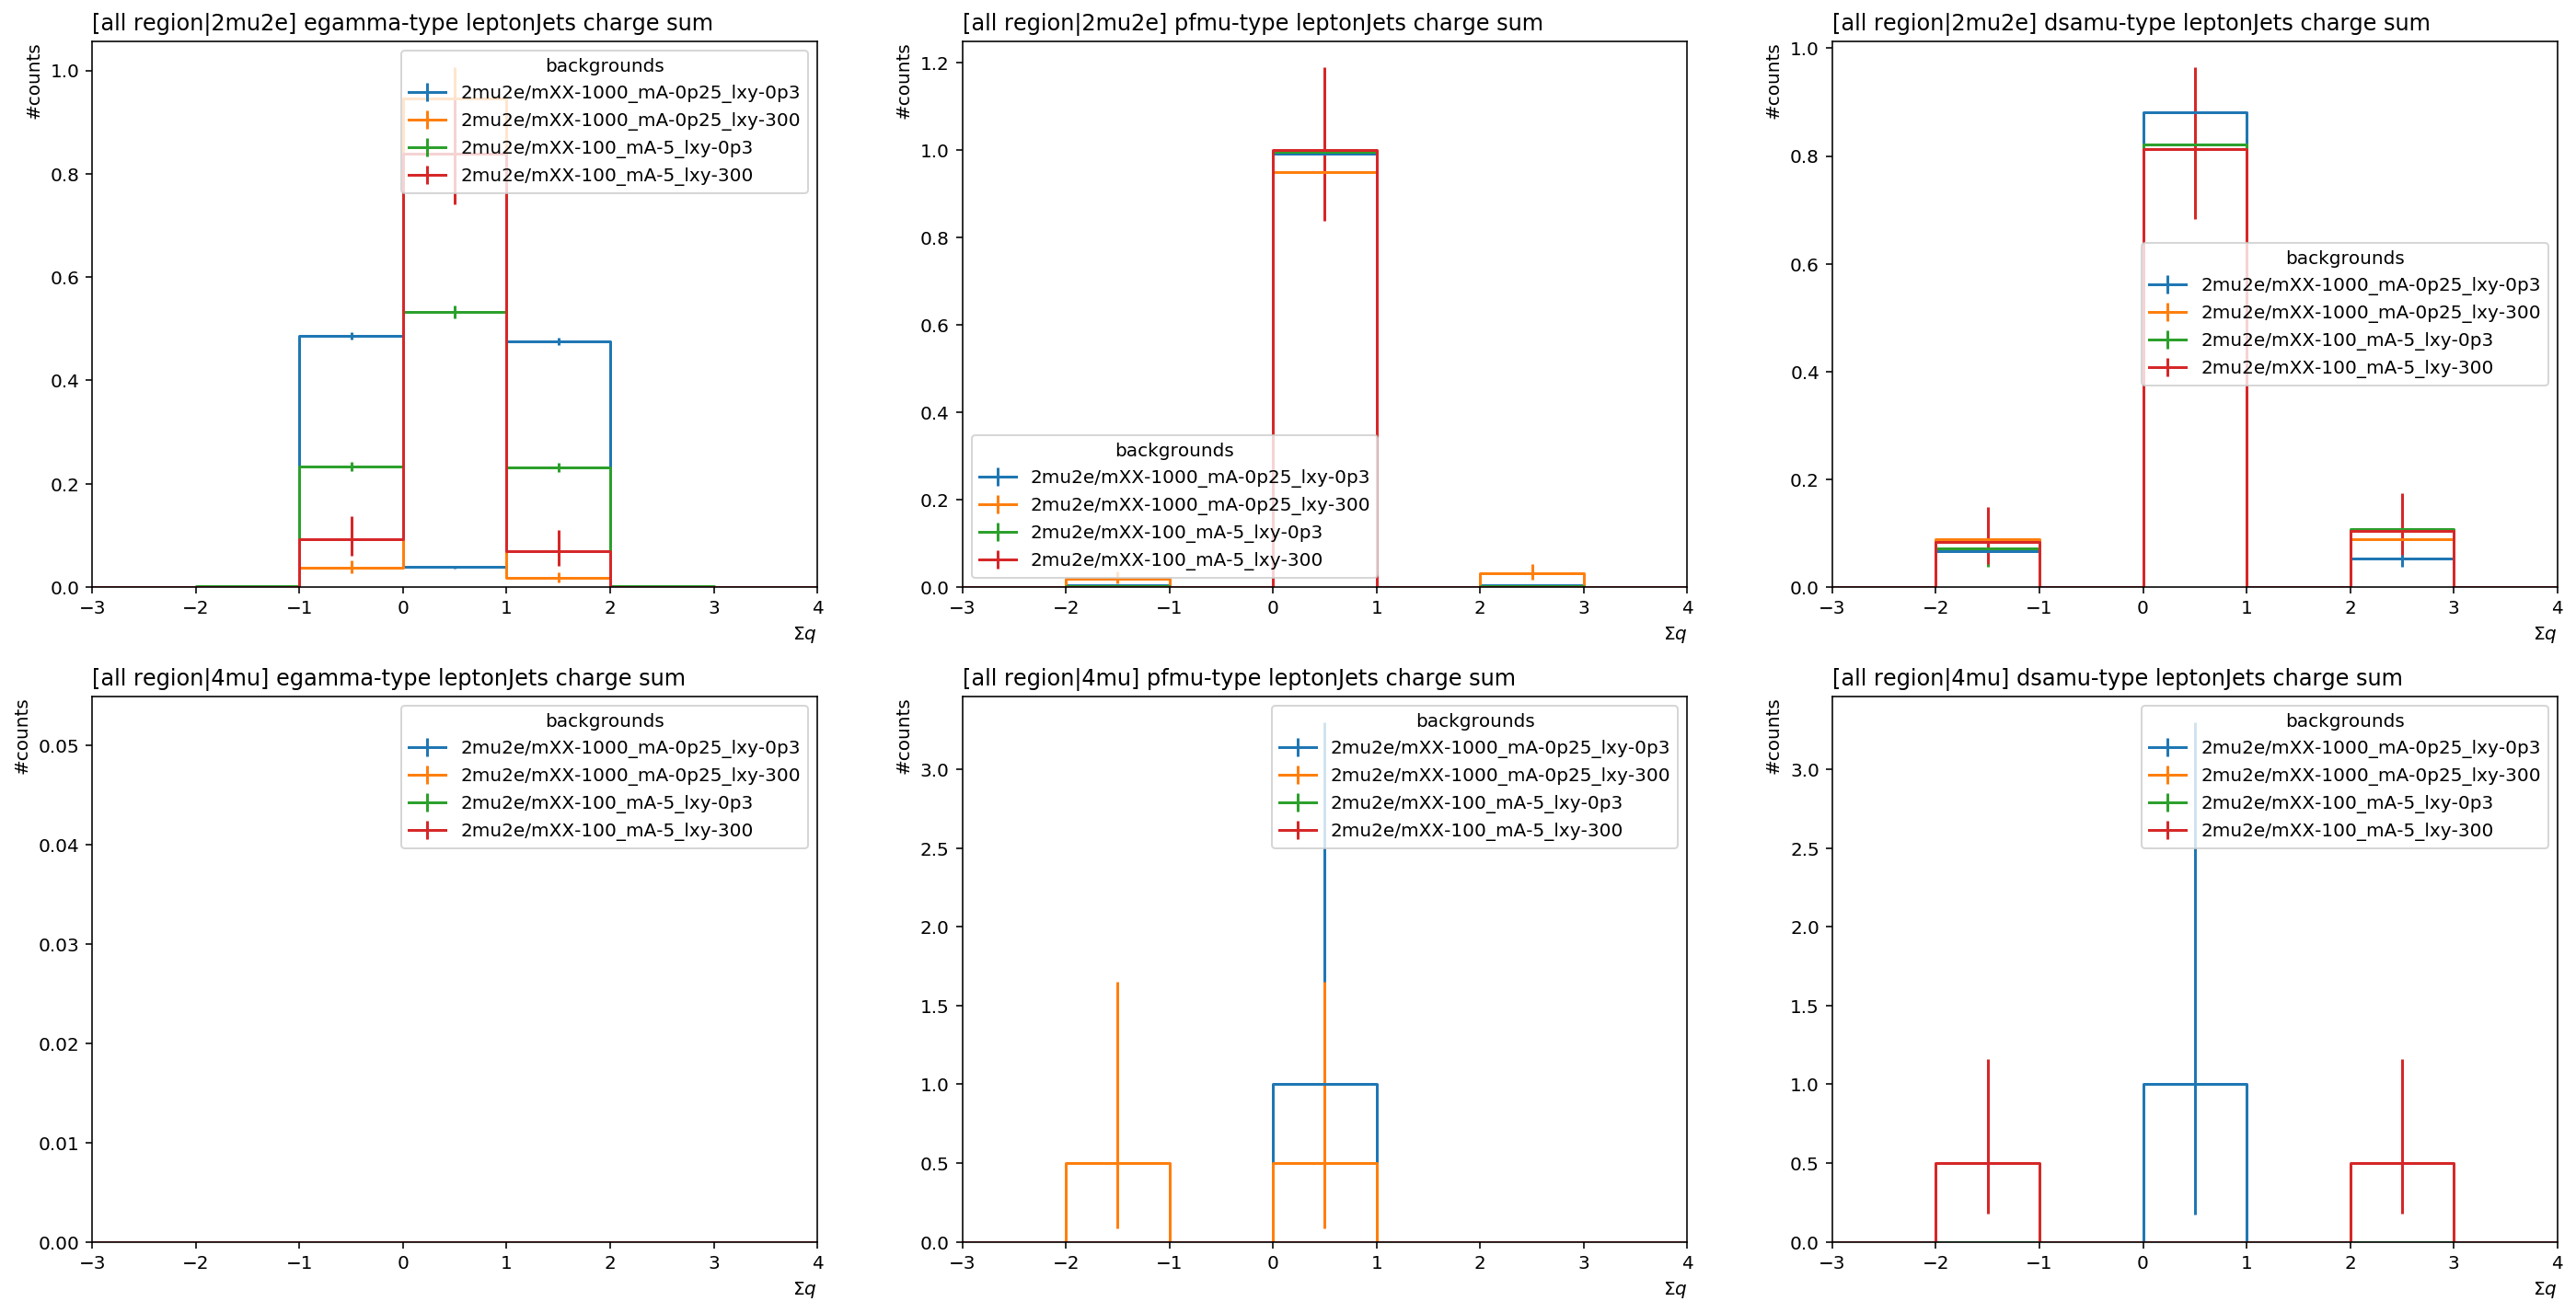

In [13]:
makeplot('ljqsum', 'charge sum', overflow='all', logy=False)